In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = torch.device("cpu")
    x = torch.ones(1, device=device)

tensor([1.], device='mps:0')


# Loading the Data

In [75]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv("df_all.csv", index_col="startTime", parse_dates=True)

# Crop the DataFrame from 2021-07-01 to 2025-06-30
df = df.loc["2021-07-01":"2025-06-30"]

# Drop unnecessary columns
df = df.drop(columns=[
    'Forecast Wind',
    'Forecast Solar',
    'Actual Wind',
    'Actual Solar',
    'Settlement Period',
])

# Calculate time of day features
minutes = df.index.hour * 60 + df.index.minute
frac_day = minutes / (24 * 60)
df['tod_sin'] = np.sin(2 * np.pi * frac_day)
df['tod_cos'] = np.cos(2 * np.pi * frac_day)

# Calculate day of week features
day_of_week = df.index.dayofweek
frac_week = day_of_week / 7
df['dow_sin'] = np.sin(2 * np.pi * frac_week)
df['dow_cos'] = np.cos(2 * np.pi * frac_week)

# Calculate month of year features
month = df.index.month
frac_year = (month - 1) / 12
df['moy_sin'] = np.sin(2 * np.pi * frac_year)
df['moy_cos'] = np.cos(2 * np.pi * frac_year)

display(df.head())

,Imbalance Price,Imbalance Volume,Market Price,Market Volume,Wind Error,Solar Error,Demand Error,De-Rated Margin (1h),Inter Delta,Non-BM,tod_sin,tod_cos,dow_sin,dow_cos,moy_sin,moy_cos
startTime,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,113.94985,308.0143,103.56,618.45,-110.976,0.0,113.0,12122.264,12.0,0.0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
2021-07-01 00:30:00,115.00000,285.1520,106.18,649.10,-107.774,2.0,512.0,12445.298,-22.0,0.0,0.130526,0.991445,0.433884,-0.900969,1.224647e-16,-1.0
2021-07-01 01:00:00,114.00000,206.0085,106.23,555.80,-147.463,0.0,742.0,12796.294,48.0,0.0,0.258819,0.965926,0.433884,-0.900969,1.224647e-16,-1.0
2021-07-01 01:30:00,115.00000,106.1017,105.74,501.70,-89.914,0.0,1066.0,12971.661,-168.0,0.0,0.382683,0.923880,0.433884,-0.900969,1.224647e-16,-1.0
2021-07-01 02:00:00,115.00000,147.7134,106.00,687.65,-2.433,0.0,1163.0,13257.469,62.0,0.0,0.500000,0.866025,0.433884,-0.900969,1.224647e-16,-1.0


/var/folders/bc/9771s35x1x92qwjdzftm3svc0000gn/T/ipykernel_62742/3377850010.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box_no.set_yticklabels(ax_box_no.get_yticks(), rotation=45)
/var/folders/bc/9771s35x1x92qwjdzftm3svc0000gn/T/ipykernel_62742/3377850010.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box_yes.set_yticklabels(ax_box_yes.get_yticks(), rotation=45)


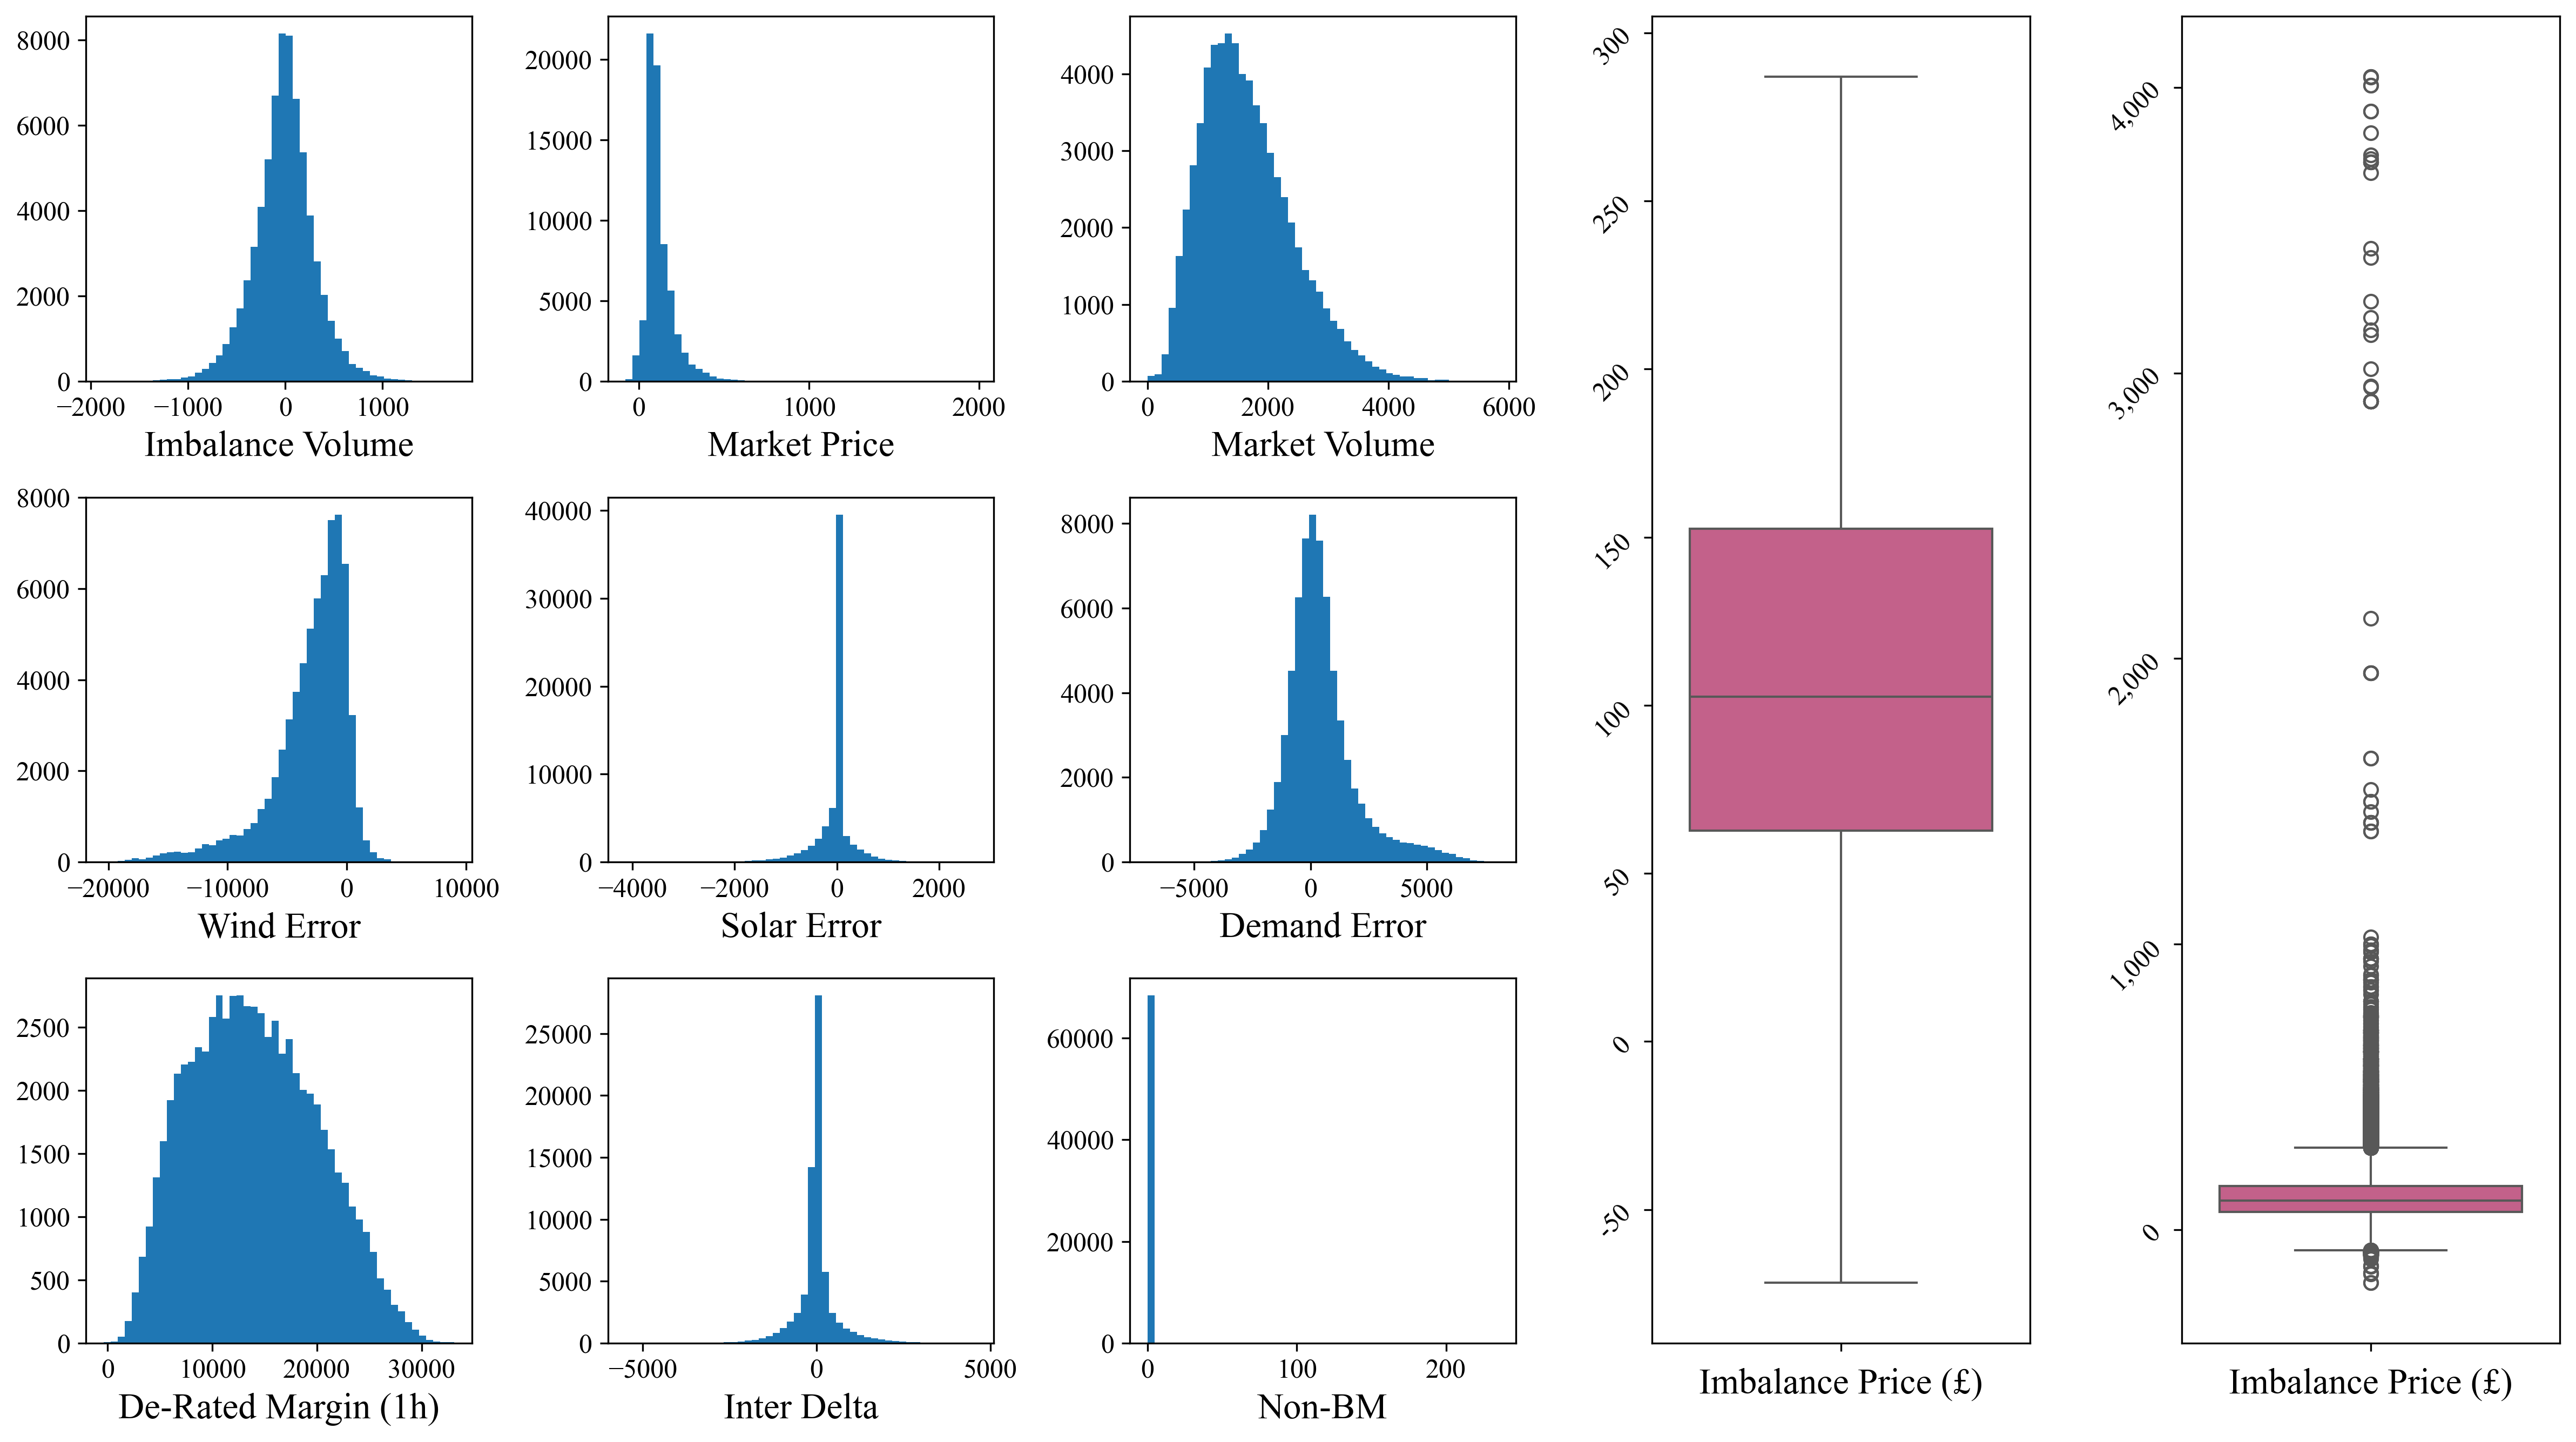

In [98]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("plots", exist_ok=True)

# Copy and reorder columns
d = df.copy()
d = d[['Imbalance Volume', 'Market Price', 'Market Volume', 'Wind Error',
       'Solar Error', 'Demand Error', 'De-Rated Margin (1h)', 'Inter Delta',
       'Non-BM', 'tod_sin', 'tod_cos', 'dow_sin', 'dow_cos',
       'moy_sin', 'moy_cos', 'Imbalance Price']]

# Create figure and axes
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(16, 9))
gs = axs[1, 2].get_gridspec()

# Remove rightmost 2 columns for custom boxplots
for ax in axs[:, -2:]:
    for a in ax:
        a.remove()

# Add two side-by-side boxplots in the last two columns
from matplotlib import gridspec
gs_boxes = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, -2:], wspace=0.4)

ax_box_no = fig.add_subplot(gs_boxes[0])
ax_box_yes = fig.add_subplot(gs_boxes[1])

# ✅ Rebuild list of only valid histogram axes
axs = [ax for row in axs[:, :-2] for ax in row]

# Columns to plot (all except cyclical features + Imbalance Price)
cols_to_plot = d.columns[:-7]

# Plot histograms
for col, ax in zip(cols_to_plot, axs):
    ax.hist(d[col], bins=50)
    ax.set_xlabel(col, size=16)
    ax.grid()

# Plot boxplot for Imbalance Price (NO outliers)
sns.boxplot(y=d["Imbalance Price"], color="#d45087", ax=ax_box_no, showfliers=False)
ax_box_no.set_yticklabels(ax_box_no.get_yticks(), rotation=45)
ax_box_no.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax_box_no.set_xlabel("Imbalance Price (£)", size=16)
ax_box_no.set_ylabel("")
ax_box_no.grid(axis="y")

# Plot boxplot for Imbalance Price (WITH outliers)
sns.boxplot(y=d["Imbalance Price"], color="#d45087", ax=ax_box_yes, showfliers=True)
ax_box_yes.set_yticklabels(ax_box_yes.get_yticks(), rotation=45)
ax_box_yes.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax_box_yes.set_xlabel("Imbalance Price (£)", size=16)
ax_box_yes.set_ylabel("")
ax_box_yes.grid(axis="y")

# Formatting
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

fig.savefig("plots/data_summary_plot", dpi=300)
plt.show()


# Hyperparameter Setup

In [99]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler

# ─── 1) Train/Val/Test Split ────────────────────────────────────────

train_end = '2025-03-01'  # start of validation
val_end   = '2025-05-01'  # start of test

# slice once …
train_df = df.loc[:train_end]
val_df   = df.loc[train_end:val_end]
test_df  = df.loc[val_end:]

# … then unpack X & y in one go without repeating .drop
X_train, y_train = train_df.drop(columns=['Imbalance Price']), train_df['Imbalance Price']
X_val,      y_val      = val_df.drop(columns=['Imbalance Price']),    val_df['Imbalance Price']
X_test,     y_test     = test_df.drop(columns=['Imbalance Price']),   test_df['Imbalance Price']


# ─── 2) Class Definitions ───────────────────────────────────────────

# ──────────── a. Dataset Definition ─────────────────────────────────

class LSTMDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return self.X.shape[0] - self.seq_len + 1

    def __getitem__(self, idx):
        x_seq    = self.X[idx : idx + self.seq_len]
        y_target = self.y[idx + self.seq_len - 1]
        return x_seq, y_target


# ──────────── b. Layer Definitions ──────────────────────────────────

class SeasonalAttn(nn.Module):
    def __init__(self, seq_len=48):
        super().__init__()
        self.attn = nn.Parameter(torch.empty(seq_len))
        nn.init.uniform_(self.attn, -0.01, 0.01)

    def forward(self, x):
        return x * self.attn.view(1, -1, 1) # (B,N,F)


class BiLSTM(nn.Module):
    def __init__(self, num_feats, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_feats,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
        )

    def forward(self, x):
        out, (_ , _) = self.lstm(x)
        return out


class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W_h = nn.Linear(input_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        e = self.v(torch.tanh(self.W_h(x)))   # (B, N, 1)
        alpha = torch.softmax(e, dim=1)       # (B, N, 1)
        context = torch.sum(alpha * x, dim=1) # (B, 2H)
        return context


# ──────────── c. Model Definitions ──────────────────────────────────

class SA_BiLSTM(nn.Module):
    def __init__(self, num_feats, seq_len=48, hidden_size=64, num_layers=2):
        super().__init__()
        self.seasonal = SeasonalAttn(seq_len)
        self.lstm = BiLSTM(num_feats, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.seasonal(x)       # (B, N, F)
        out = self.lstm(x)         # (B, N, 2H)
        last = out[:, -1, :]       # (B, 2H)
        return self.fc(last).squeeze(-1)  # (B,)


class SA_BiLSTM_AttnPool(nn.Module):
    def __init__(self, num_feats, seq_len=48, hidden_size=64, num_layers=2):
        super().__init__()
        self.seasonal = SeasonalAttn(seq_len)
        self.lstm = BiLSTM(num_feats, hidden_size, num_layers)
        self.pool = AttentionPool(input_dim=hidden_size * 2, hidden_dim=hidden_size)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.seasonal(x)       # (B, N, F)
        out = self.lstm(x)         # (B, N, 2H)
        context = self.pool(out)   # (B, 2H)
        return self.fc(context).squeeze(-1)  # (B,)


# ─── 3) Device ───────────────────────────────────────────────────────

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


# ─── 4) Time‐feature lists and scaler ────────────────────────────────

time_feats  = ['tod_sin','tod_cos','dow_sin','dow_cos','moy_sin','moy_cos']
other_feats = [c for c in X_train.columns if c not in time_feats]


# ─── 5) CV Splitter & Hyperparameters ───────────────────────────────

TRANSFORMER_FACTORY = {
    "MinMax": MinMaxScaler,
    "Robust": RobustScaler,
    "Standard": StandardScaler,
    "MaxAbs": MaxAbsScaler
}
MODEL_FACTORY = {
    "SA_BiLSTM": SA_BiLSTM,
    "SA_BiLSTM_AttnPool": SA_BiLSTM_AttnPool
}
LOSS_FACTORY = {
    "MAE": nn.L1Loss,
    "MSE": nn.MSELoss,
    "Huber": nn.SmoothL1Loss
}

seq_len     = 48
batch_size  = 128
lr          = 1e-4
hidden_size = 64
num_layers  = 2
max_epochs  = 200
patience    = 20
scaler_used = "MaxAbs"
model_used  = "SA_BiLSTM"
loss_used   = "Huber"
beta        = 0.01 # For Huber loss only

# ─── 6) Model Tag & Directory ────────────────────────────────────────         

md = {
    "model":         model_used,
    "scaler":        scaler_used,
    "loss":          loss_used,
    "learning_rate": lr,
    "batch_size":    batch_size,
    "hidden_size":   hidden_size,
    "num_layers":    num_layers,
    "seq_len":       seq_len,
    "max_epochs":    max_epochs,
    "patience":      patience,
}

initials = lambda s: "".join(w[0] for w in s.split("_"))

parts = []
for k, v in md.items():
    if k in ("model", "scaler", "loss"):
        s = str(v)
    else:
        # convert to string and clip leading “0.”
        s = str(v)
        if isinstance(v, float) and s.startswith("0."):
            s = s.replace("0.", ".")
        # prefix with initials for non-string params
        s = f"{initials(k)}{s}"
    parts.append(s)
tag = "_".join(parts)

models_root = "models"
candidate   = os.path.join(models_root, tag)
version     = 0

while os.path.exists(candidate):
    version   += 1
    candidate = f"{os.path.join(models_root, tag)}_v{version}"

# ─── Create directory ──────────────────────────────────────────────
os.makedirs(candidate, exist_ok=True)
base_dir = candidate
print(f"→ Saving run in: {base_dir}")

Using device: mps
→ Saving run in: models/SA_BiLSTM_MaxAbs_Huber_lr.0001_bs128_hs64_nl2_sl48_me200_p20_v4


# Training

In [ ]:
# ─── TEST-EVALUATION + EARLY STOPPING ────────────────────────────────
import os, json, copy
import numpy as np
import torch
import sys, random
import joblib
from datetime import datetime, timezone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ─────────────────────────────────────────────────────────────────────
# ─── 1) SCALE TRAIN/VAL/TEST ─────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────
scaler = TRANSFORMER_FACTORY[scaler_used]()
transformer = ColumnTransformer(
    [('scale', scaler, other_feats)],
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_tr_np  = transformer.fit_transform(X_train)
X_val_np = transformer.transform(X_val)
X_te_np  = transformer.transform(X_test)

scaler_y = MinMaxScaler().fit(y_train.values.reshape(-1,1))
y_tr_np  = scaler_y.transform(y_train.values.reshape(-1,1)).flatten()
y_val_np = scaler_y.transform(y_val.values.reshape(-1,1)).flatten()
y_te_np  = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()


# ─────────────────────────────────────────────────────────────────────
# ─── 2) BUILD DATALOADERS ────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────
train_loader = DataLoader(LSTMDataset(X_tr_np,  y_tr_np,  seq_len),
                          batch_size=batch_size, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(LSTMDataset(X_val_np, y_val_np, seq_len),
                          batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(LSTMDataset(X_te_np,  y_te_np,  seq_len),
                          batch_size=batch_size, shuffle=False, pin_memory=True)

# ─────────────────────────────────────────────────────────────────────
# ─── 3) INSTANTIATE MODEL, OPTIMIZER, CRITERION ──────────────────────
# ─────────────────────────────────────────────────────────────────────
model = MODEL_FACTORY[model_used](
    num_feats=X_tr_np.shape[1],
    hidden_size=hidden_size,
    num_layers=num_layers,
    seq_len=seq_len
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if loss_used.startswith("Huber"):
    criterion = LOSS_FACTORY[loss_used](beta=beta)
else:
    criterion = LOSS_FACTORY[loss_used]()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7
)

# ─────────────────────────────────────────────────────────────────────
# ─── 4) TRAIN w/ EARLY STOPPING ON VAL ───────────────────────────────
# ─────────────────────────────────────────────────────────────────────
best_val = float('inf')
best_ckpt = None
epochs_no_improve = 0

for epoch in range(1, max_epochs+1):
    # — train —
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb).squeeze(-1), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # — validate —
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb).squeeze(-1), yb).item()
    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    print(f"[Epoch {epoch:03d}] train={train_loss:.5f}  val={val_loss:.5f}")

    # — early stop check —
    if val_loss < best_val:
        best_val = val_loss
        epochs_no_improve = 0
        # keep a copy of best weights
        best_ckpt = {
            'model':     copy.deepcopy(model.state_dict()),
            'optimizer': copy.deepcopy(optimizer.state_dict())
        }
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"→ early stopping after {epoch} epochs")
            break

# restore best model
model.load_state_dict(best_ckpt['model'])
optimizer.load_state_dict(best_ckpt['optimizer'])

# ─────────────────────────────────────────────────────────────────────
# # ─── 5) INFERENCE ON TEST ──────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────
model.eval()
scaled_preds, scaled_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        p  = model(xb).squeeze(-1).cpu().numpy()
        scaled_preds.append(p)
        scaled_trues.append(yb.numpy())
scaled_preds = np.concatenate(scaled_preds)
scaled_trues = np.concatenate(scaled_trues)

# invert scaling
preds_gbp  = scaler_y.inverse_transform(scaled_preds.reshape(-1,1)).flatten()
trues_gbp  = scaler_y.inverse_transform(scaled_trues.reshape(-1,1)).flatten()
err        = trues_gbp - preds_gbp

# compute metrics
mae        = mean_absolute_error(trues_gbp, preds_gbp)
rmse       = np.sqrt(mean_squared_error(trues_gbp, preds_gbp))
smape      = np.mean(2.0 * np.abs(err) /
                    (np.abs(trues_gbp) + np.abs(preds_gbp) + 1e-8)) * 100
huber_loss = np.where(np.abs(err) <= beta,
                      0.5 * err**2 / beta,
                      np.abs(err) - 0.5 * beta)
huber      = huber_loss.mean()

print(f"\nTEST → MAE={mae:.4f}, RMSE={rmse:.4f}, SMAPE={smape:.4f}%, Huber={huber:.4f}")


# ─────────────────────────────────────────────────────────────────────
# ─── 6) BUILD METADATA ───────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────
# a. Environment metadata
env_meta = {
    "seed_torch":           torch.initial_seed(),
    "seed_numpy":           np.random.get_state()[1][0],
    "seed_python":          random.getstate()[1][0],
    "cudnn_deterministic":  torch.backends.cudnn.deterministic,
    "cudnn_benchmark":      torch.backends.cudnn.benchmark,
    "torch_version":        torch.__version__,
    "python_version":       sys.version.split()[0],
    "run_timestamp":        datetime.now(timezone.utc).isoformat()
}

# b. Data split & shapes
data_meta = {
    "train_end": train_end,
    "val_end":   val_end,
    "seq_len":   seq_len,
    "n_train":   len(train_loader.dataset),
    "n_val":     len(val_loader.dataset),
    "n_test":    len(test_loader.dataset)
}

# c. Feature‐engineering choices
feat_meta = {
    "time_feats":      time_feats,
    "other_feats":     other_feats,
    "n_features":      X_tr_np.shape[1],
    "scaler":          scaler_used,
    "scaler_params":   transformer.named_transformers_['scale'].get_params()
}

# d. DataLoader settings
loader_meta = {
    "batch_size":  batch_size,
    "shuffle":     True,
    "num_workers": 0,
    "pin_memory":  True,
    "device":      str(device)
}

# e. Core hyperparameters
hyperparams = {
    "model":          model_used,
    "scaler":         scaler_used,
    "loss":           loss_used,
    **({"beta": beta} if loss_used == "Huber" else {}),
    "learning_rate":  lr,
    "batch_size":     batch_size,
    "hidden_size":    hidden_size,
    "num_layers":     num_layers,
    "seq_len":        seq_len
}

# f. Optimizer metadata
optim_meta = {
    "type": optimizer.__class__.__name__,
    "lr":   optimizer.defaults.get("lr"),
    **{k: optimizer.defaults[k]
       for k in ("betas","eps","weight_decay")
       if k in optimizer.defaults}
}

# g. Scheduler metadata
sched_meta = {
    "type":     scheduler.__class__.__name__,
    "mode":     getattr(scheduler, "mode", None),
    "factor":   getattr(scheduler, "factor", None),
    "patience": getattr(scheduler, "patience", None),
    "min_lr":   (scheduler.min_lrs[0]
                 if hasattr(scheduler, "min_lrs")
                 else getattr(scheduler, "eta_min", None))
}

# h. Early‐stop metadata
earlystop_meta = {
    "max_epochs": max_epochs,
    "patience":   patience
}

# i. Metrics
metrics_meta = {
    "mae":   float(mae),
    "rmse":  float(rmse),
    "smape": float(smape),
    "huber": float(huber)
}


# ─────────────────────────────────────────────────────────────────────
# ─── 7) SAVE CHECKPOINT & SUMMARY ────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────
# Build and save the PyTorch checkpoint
torch.save({
    "model_state_dict":     model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
}, os.path.join(base_dir, "torch_model.pt"))
print(f"✅ Saved model to {base_dir}/torch_model.pt")

# Save scikit objects with joblib
joblib.dump({
    "transformer": transformer,
    "scaler_y":    scaler_y
}, os.path.join(base_dir, "scikit_objects.joblib"))
print(f"✅ Saved scikit objects to {base_dir}/scikit_objects.joblib")

# Build and save the human-readable JSON summary
final_summary = {
    "environment":  env_meta,
    "data":         data_meta,
    "features":     feat_meta,
    "dataloader":   loader_meta,
    "hyperparams":  hyperparams,
    "optimizer":    optim_meta,
    "scheduler":    sched_meta,
    "early_stop":   earlystop_meta,
    "metrics":      metrics_meta,
}

with open(os.path.join(base_dir, "test_summary.json"), "w") as f:
    json.dump(final_summary, f, indent=2)
print(f"✅ Saved json summary to {base_dir}/test_summary.json")


# Loading a saved model

In [ ]:
import os
import json
import joblib
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ─── Make sure your MODEL_FACTORY is in scope ────────────────────────
# from your_module import MODEL_FACTORY

# 1) Device
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps"  if torch.backends.mps.is_available() else
    "cpu"
)

# 2) Gather saved runs
models_dir = "models"
runs = sorted(
    d for d in os.listdir(models_dir)
    if os.path.isdir(os.path.join(models_dir, d))
)

dd  = widgets.Dropdown(options=runs, description="Run:", layout=widgets.Layout(width="60%"))
btn = widgets.Button(description="Load", button_style="success")
out = widgets.Output()

# 3) Scheduler factory for future‐proofing
SCHEDULER_FACTORY = {
    "ReduceLROnPlateau": lambda opt, cfg: ReduceLROnPlateau(
        opt,
        mode     = cfg.get("mode",     "min"),
        factor   = cfg.get("factor",   0.5),
        patience = cfg.get("patience", 5),
        min_lr   = cfg.get("min_lr",   1e-7)
    ),
    # add other schedulers here as needed
}

def on_load(_):
    run     = dd.value
    run_dir = os.path.join(models_dir, run)

    # a) Load JSON summary
    with open(os.path.join(run_dir, "test_summary.json"), "r") as f:
        summary = json.load(f)
    hp         = summary["hyperparams"]
    feat_meta  = summary["features"]
    sched_meta = summary["scheduler"]
    metrics    = summary.get("metrics", {})

    # b) Infer input dimension
    num_feats = feat_meta["n_features"]

    # c) Rebuild model
    model_cls = MODEL_FACTORY[hp["model"]]
    model     = model_cls(
                    num_feats   = num_feats,
                    hidden_size = hp["hidden_size"],
                    num_layers  = hp["num_layers"],
                    seq_len     = hp["seq_len"]
                ).to(device)

    # d) Rebuild optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["learning_rate"])

    # e) Rebuild scheduler via factory
    scheduler = SCHEDULER_FACTORY[sched_meta["type"]](optimizer, sched_meta)

    # f) Load PyTorch weights
    ckpt = torch.load(
        os.path.join(run_dir, "torch_model.pt"),
        map_location=device,
        weights_only=False
    )
    model.load_state_dict(    ckpt["model_state_dict"]    )
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    scheduler.load_state_dict(ckpt["scheduler_state_dict"])
    model.to(device)

    # g) Load sklearn objects
    scikit = joblib.load(os.path.join(run_dir, "scikit_objects.joblib"))
    transformer = scikit["transformer"]
    scaler_y    = scikit["scaler_y"]

    # h) Expose to globals
    globals().update({
        "model":       model,
        "optimizer":   optimizer,
        "scheduler":   scheduler,
        "transformer": transformer,
        "scaler_y":    scaler_y,
        "summary":     summary,
        "base_dir":    run_dir,
    })

    with out:
        clear_output()
        print(f"✅ Loaded run '{run}' on {device}\n")
        print("Hyperparameters:")
        print(json.dumps(hp, indent=2))
        print("\nScheduler settings:")
        print(json.dumps(sched_meta, indent=2))
        print("\nMetrics:")
        print(json.dumps({k: round(v,3) for k, v in metrics.items()}, indent=2))

btn.on_click(on_load)
display(dd, btn, out)


Dropdown(description='Run:', layout=Layout(width='60%'), options=('SA_BiLSTM_MaxAbs_Huber_lr.0001_bs128_hs64_n…

Button(button_style='success', description='Load', style=ButtonStyle())

Output()

# Testing Only

In [112]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader

# Pull hyperparams from summary
seq_len    = summary['hyperparams']['seq_len']
batch_size = summary['hyperparams']['batch_size']

# 1) Transform test set (X_test, y_test already in memory)
X_te_np = transformer.transform(X_test)
y_te_np = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

# 2) Build DataLoader
test_loader = DataLoader(
    LSTMDataset(X_te_np, y_te_np, seq_len),
    batch_size=batch_size, shuffle=False
)

# 3) Inference
model.eval()
scaled_preds, scaled_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        p  = model(xb).cpu().numpy()
        scaled_preds.append(p)
        scaled_trues.append(yb.numpy())
scaled_preds = np.concatenate(scaled_preds)
scaled_trues = np.concatenate(scaled_trues)

# 4) Inverse‐scale back to original units
preds_orig = scaler_y.inverse_transform(scaled_preds.reshape(-1,1)).flatten()
trues_orig = scaler_y.inverse_transform(scaled_trues.reshape(-1,1)).flatten()

# 5) Compute metrics
mae_val  = mean_absolute_error(trues_orig, preds_orig)
rmse_val = np.sqrt(mean_squared_error(trues_orig, preds_orig))
smape_val = np.mean(2.0 * np.abs(trues_orig - preds_orig) /
                    (np.abs(trues_orig) + np.abs(preds_orig) + 1e-8)) * 100
r2 = r2_score(trues_orig, preds_orig)

print(f"Test MAE:   £{mae_val:.2f}")
print(f"Test RMSE:  £{rmse_val:.2f}")
print(f"Test sMAPE: {smape_val:.2f}%")
print(f"Test R²:     {r2:.3f}")

Test MAE:   £11.05
Test RMSE:  £14.39
Test sMAPE: 32.69%
Test R²:     0.877


# Plots

In [ ]:
import os
import matplotlib.pyplot as plt

# Create plots directory in the current model run directory
plots_dir = os.path.join(base_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

# Also keep a general plots directory for cases when no model is loaded
os.makedirs("plots", exist_ok=True)

plt.rcParams.update({
    # Resolution
    "figure.dpi": 300,
    # Font
    "font.family": "Times New Roman",
    "mathtext.fontset": "stix",
    # Figure size (optional – adjust as needed)
    "figure.figsize": (10, 6),
    # Title and label font sizes
    "figure.titlesize": 18,    # overall figure title
    "axes.titlesize": 18,      # axes title
    "axes.labelsize": 14,      # x/y axis labels
    # Tick label size
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    # Legend
    "legend.fontsize": 12,
    # Line width (for plot lines)
    "lines.linewidth": 1.5,
    # Grid styling (optional)
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})



## Predicted vs. True

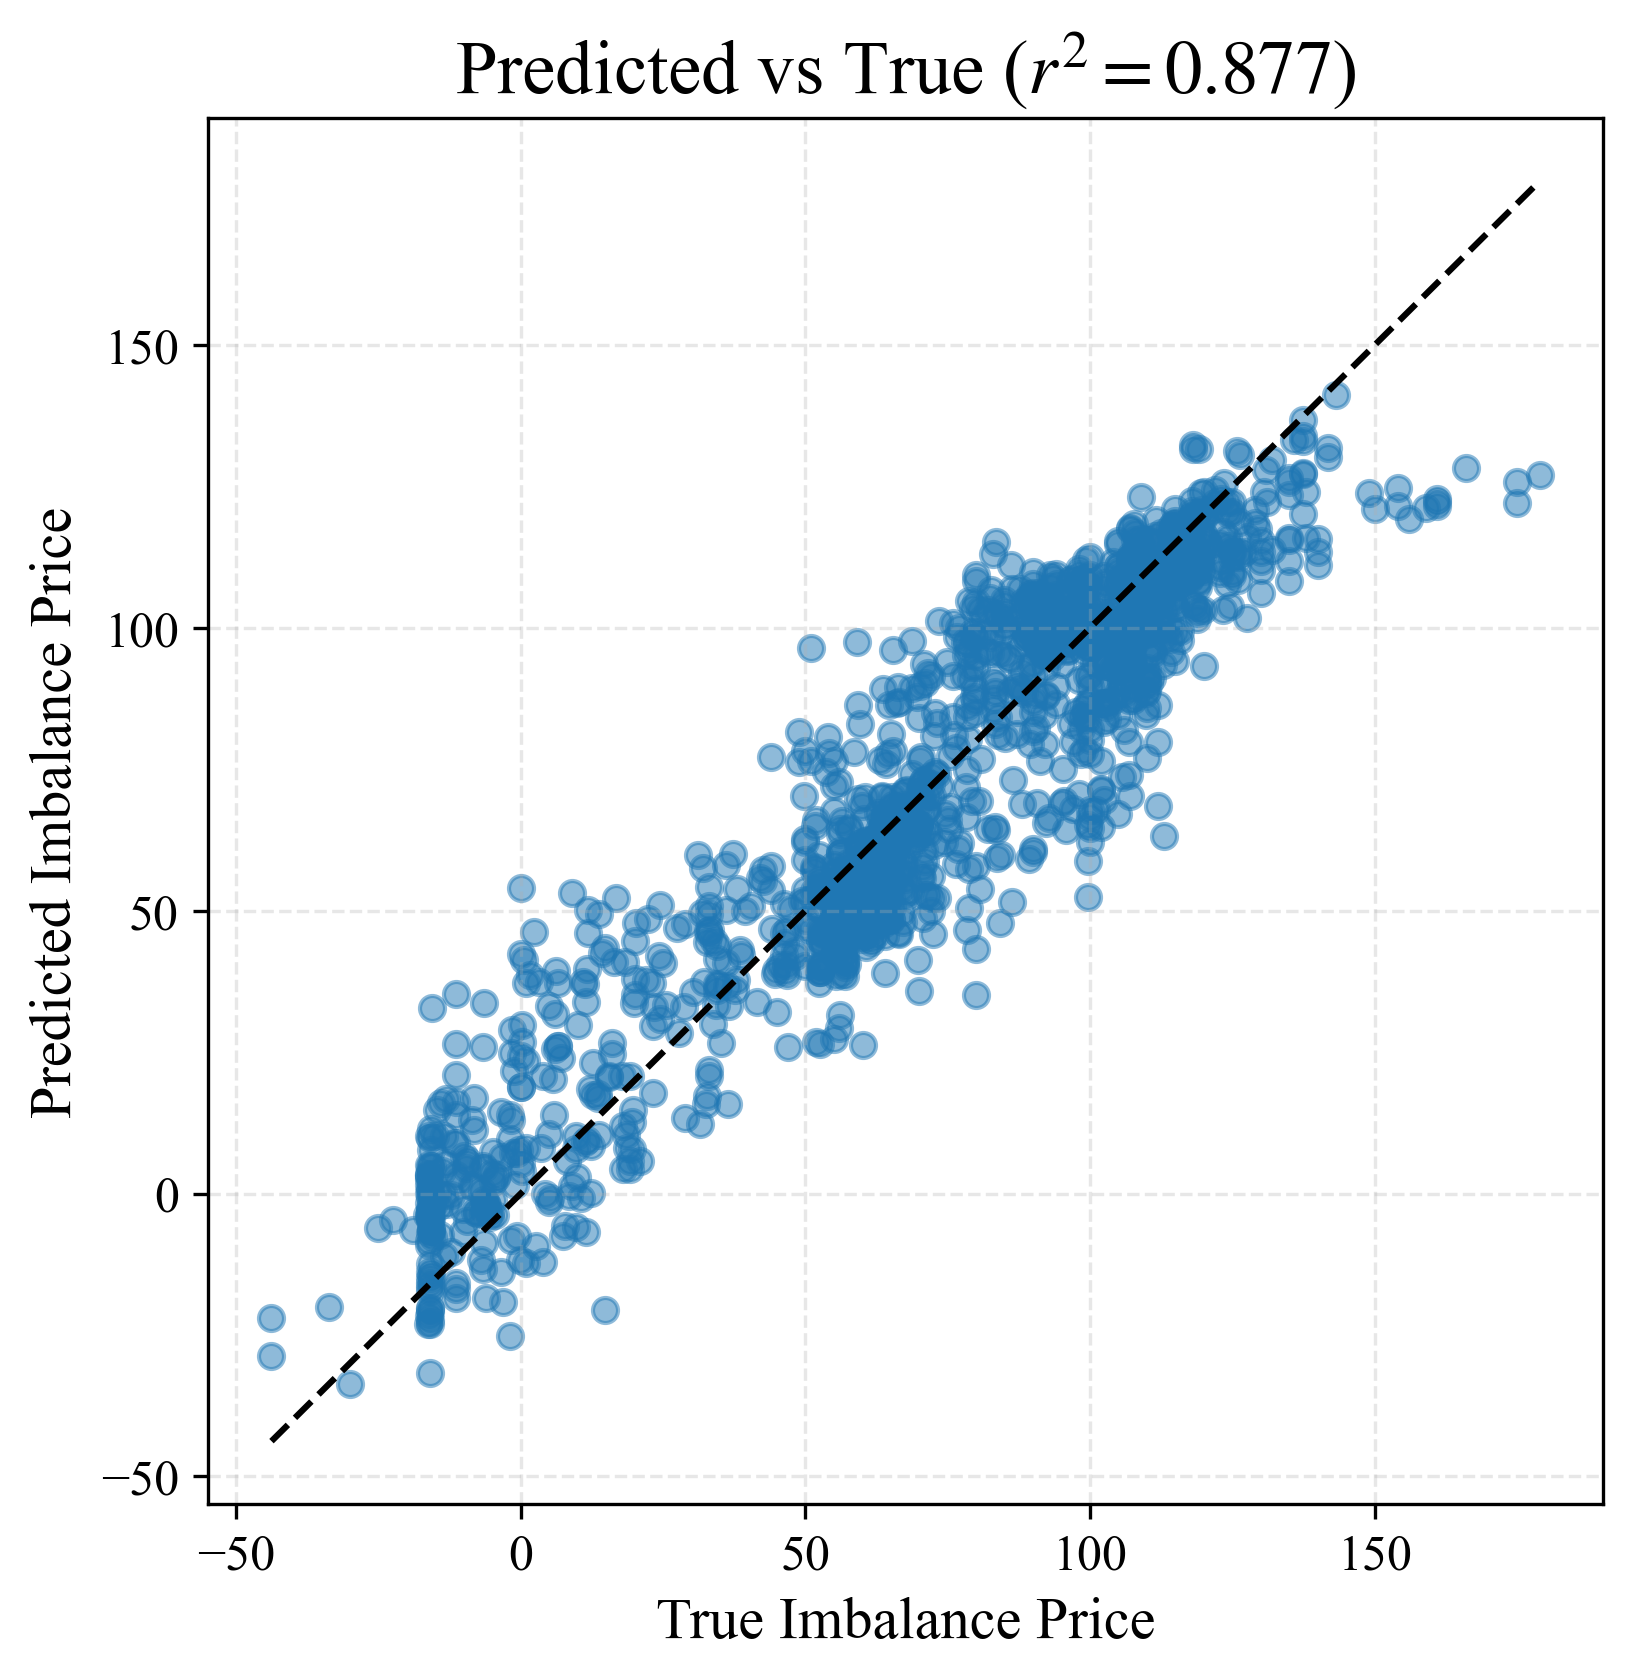

In [113]:
plt.figure(figsize=(6,6))
plt.scatter(trues_orig, preds_orig, alpha=0.5)
mn, mx = trues_orig.min(), trues_orig.max()
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('True Imbalance Price')
plt.ylabel('Predicted Imbalance Price')
plt.title(rf'Predicted vs True ($r^2 = {r2:.3f}$)')
plt.grid(True)
plt.savefig(os.path.join(plots_dir, "predicted_vs_true.png"), dpi=300)
plt.show()

## Residuals Histogram

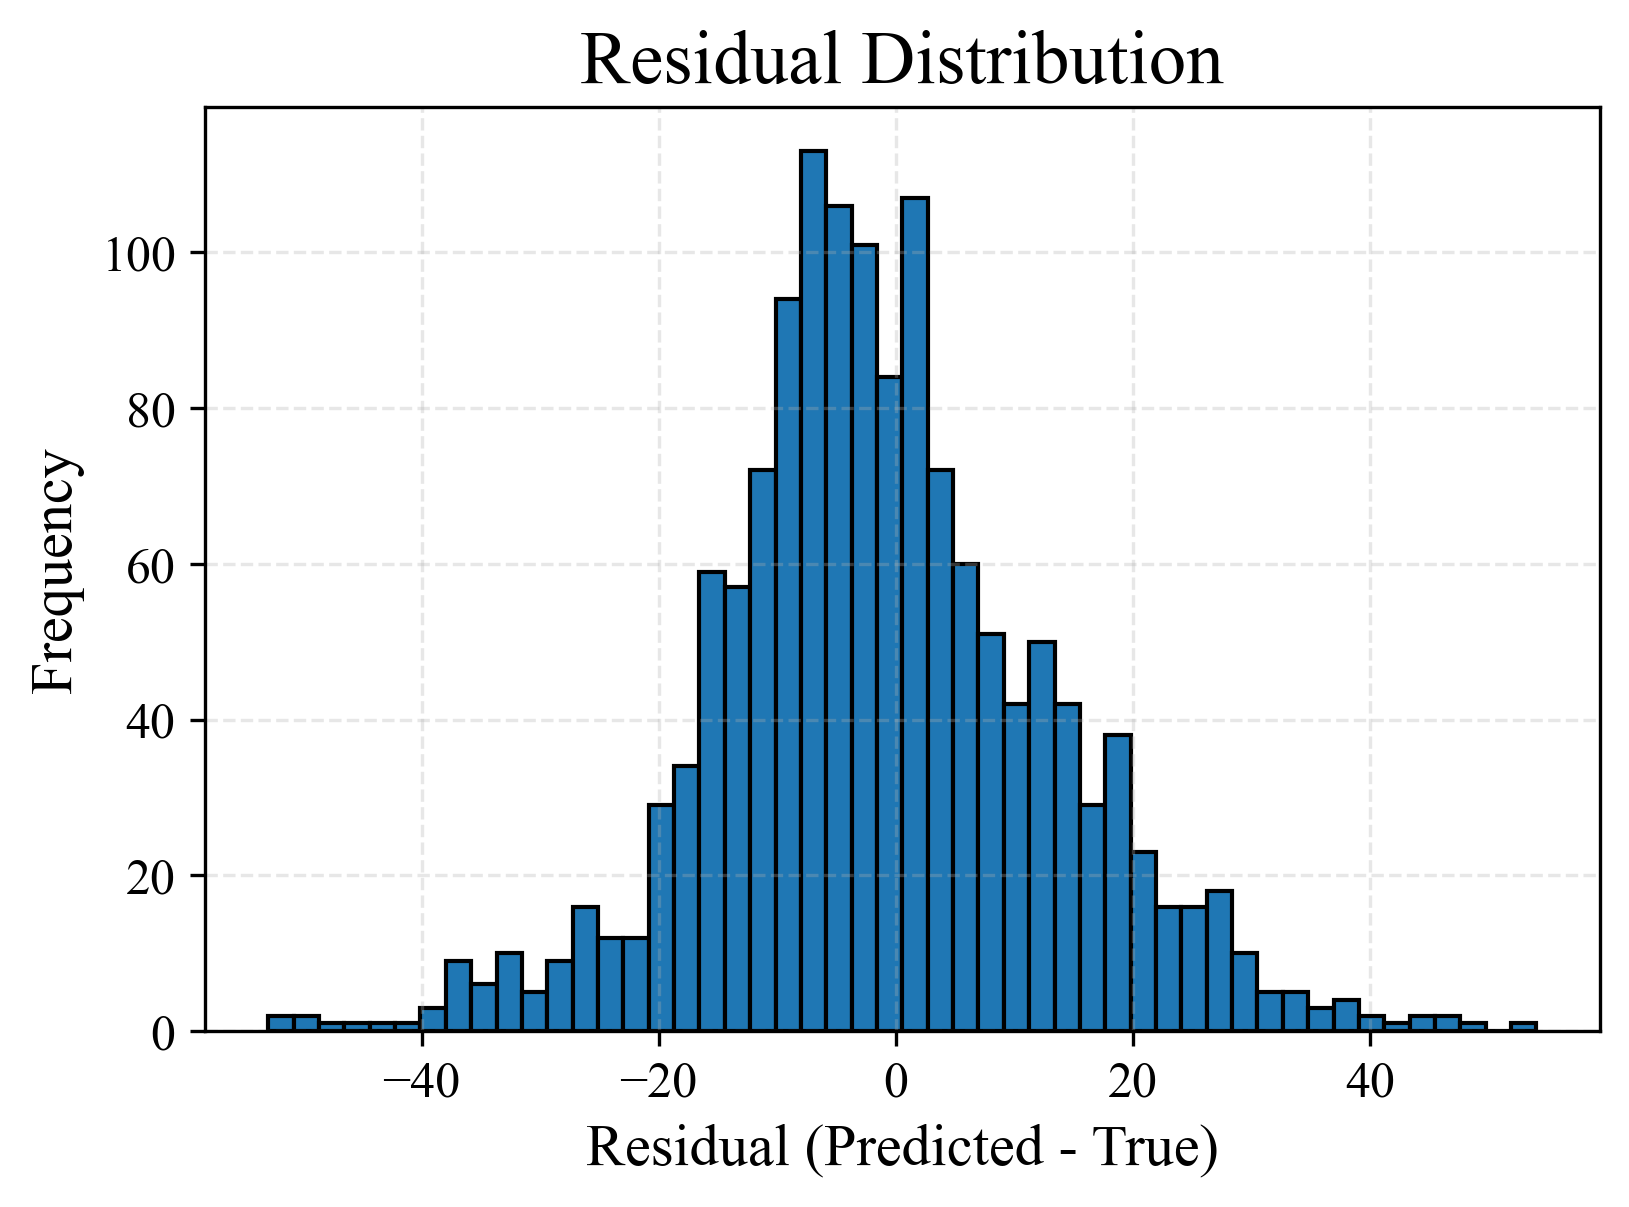

In [114]:
residuals = preds_orig - trues_orig
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True)
plt.savefig(os.path.join(plots_dir, "residuals_histogram.png"), dpi=300)
plt.show()

## True vs. Predicted - Time Series

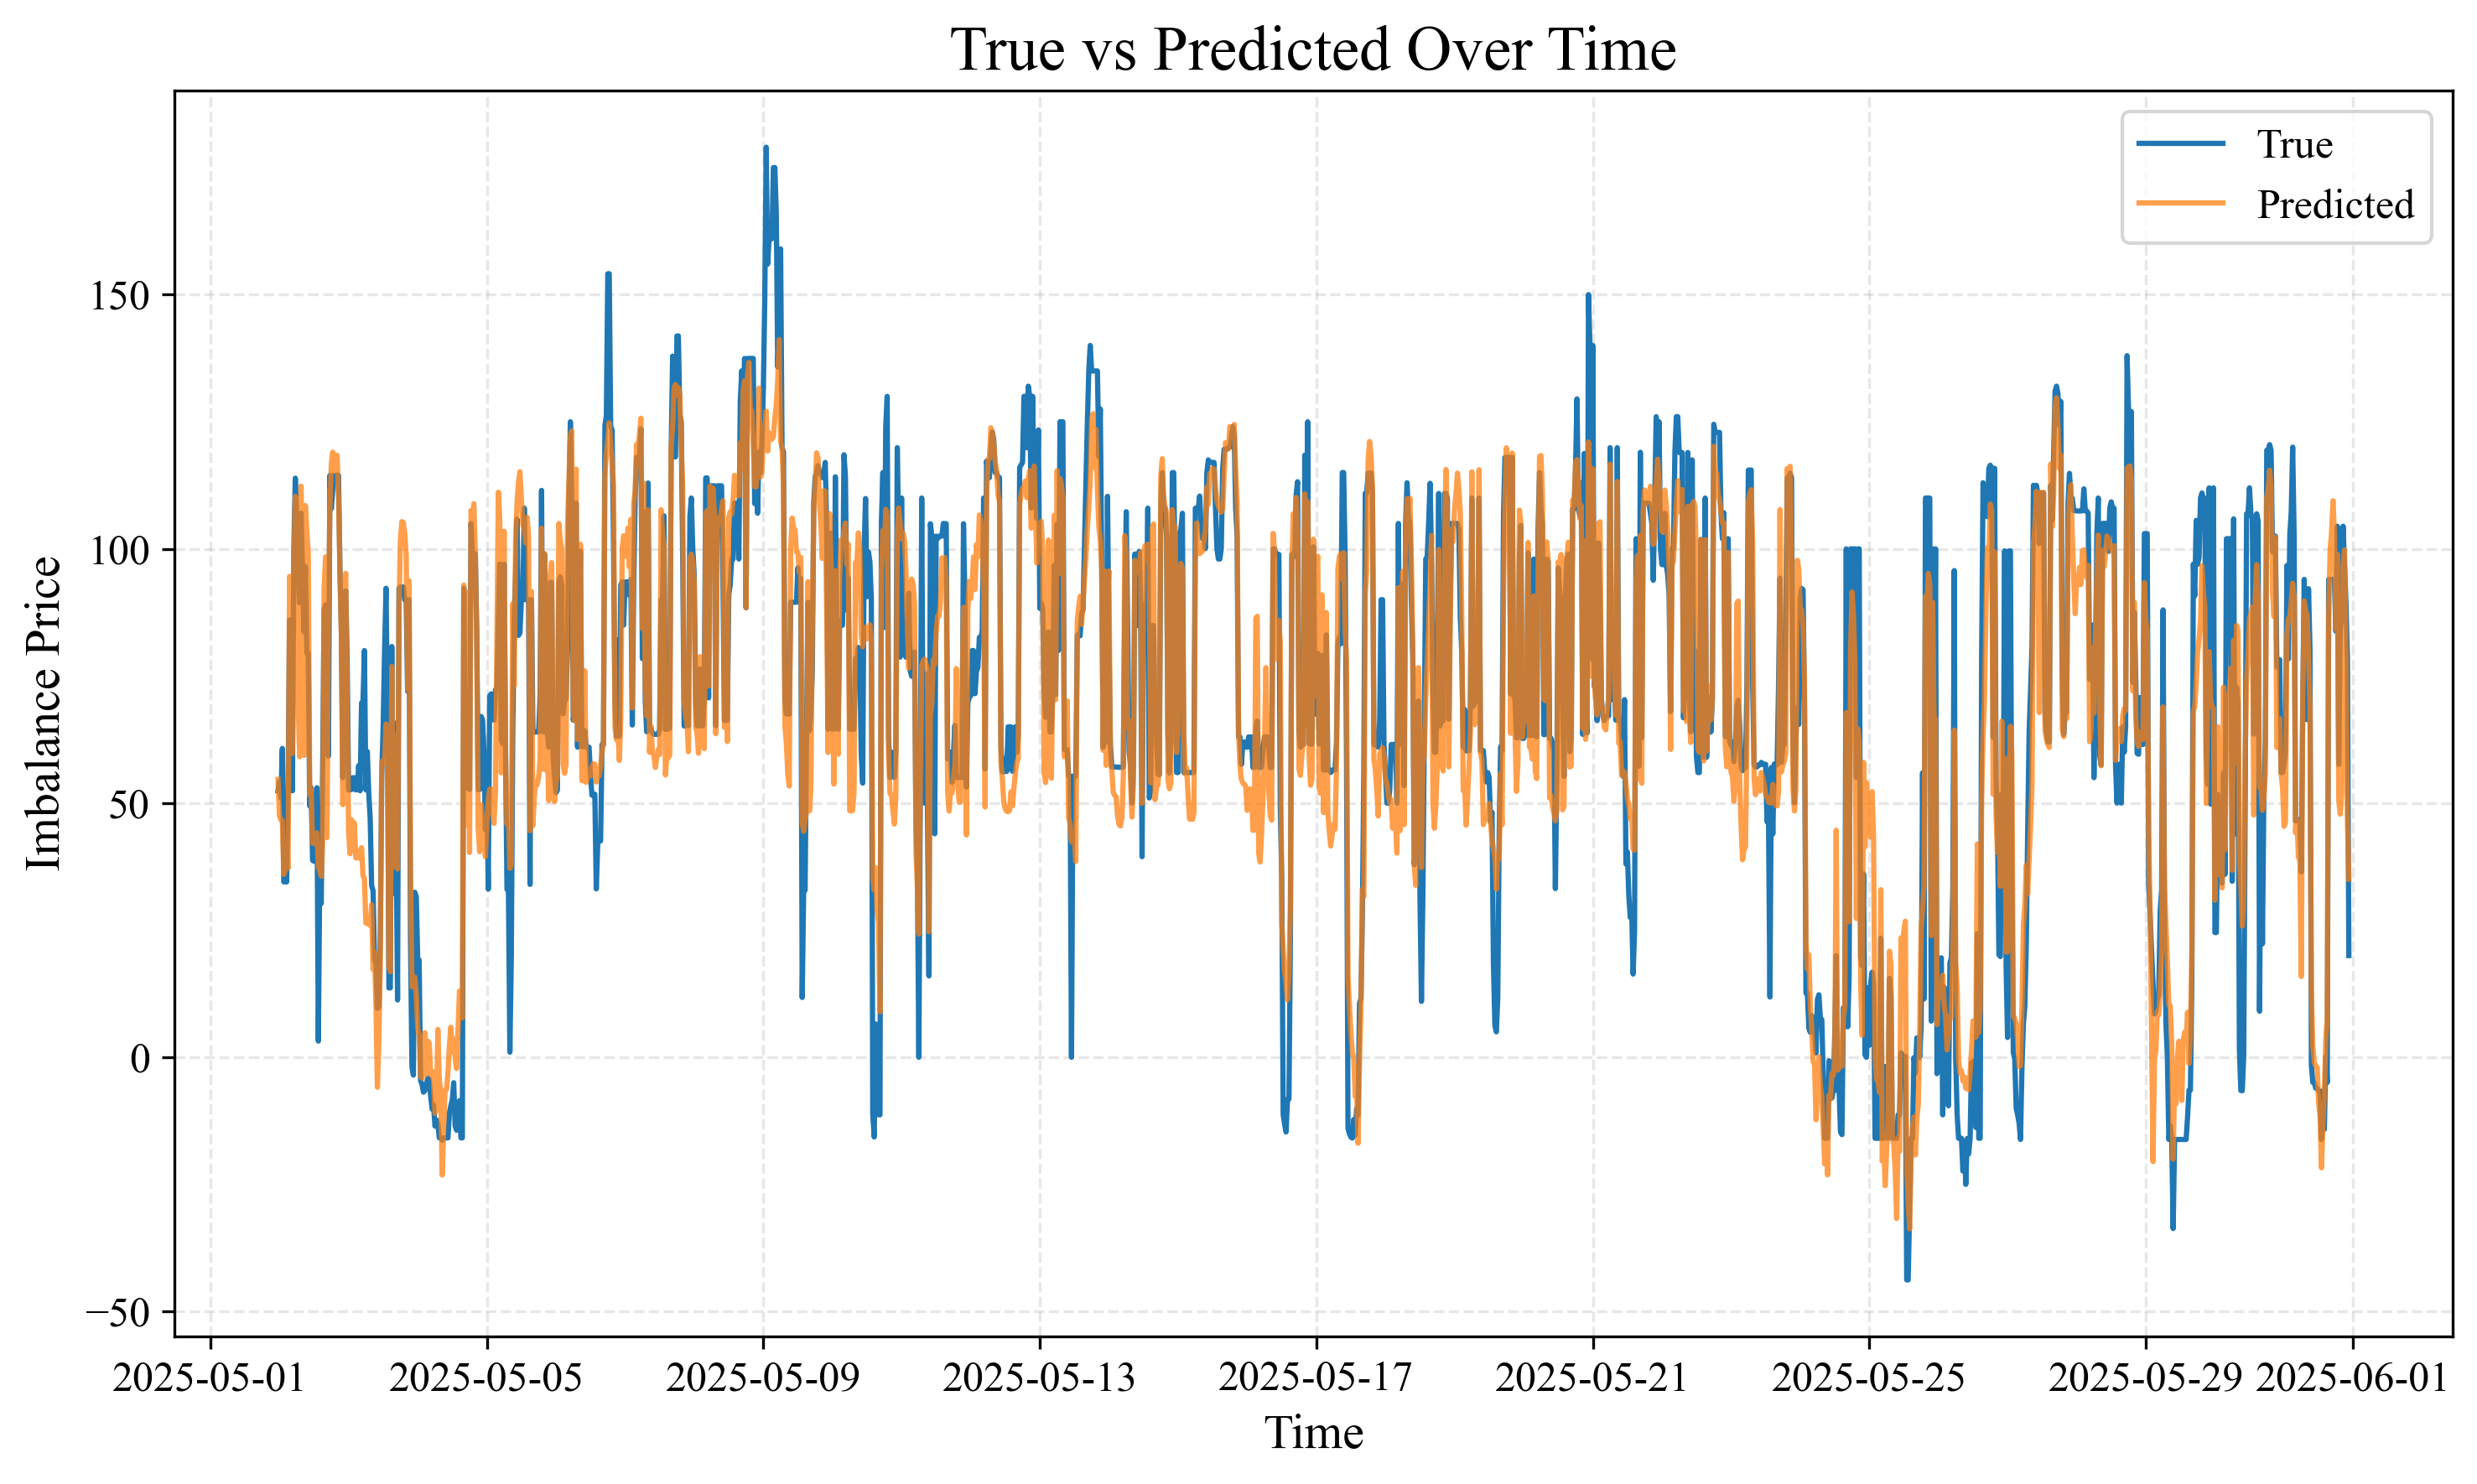

In [115]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index[seq_len-1:], trues_orig, label="True")
plt.plot(test_df.index[seq_len-1:], preds_orig, label="Predicted", alpha=0.75)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Imbalance Price")
plt.title("True vs Predicted Over Time")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "true_vs_predicted_over_time.png"), dpi=300)
plt.show()

# SHAP

In [107]:
import torch
import torch.nn as nn
import shap
import pandas as pd
from torch.utils.data import DataLoader

def unscale_shap(shap_arr, baseline, scaler):
    """
    shap_arr: ndarray of SHAP values in scaled space
    baseline: float baseline value in scaled space
    scaler:   your fitted sklearn scaler_y
    Returns: (shap_orig, baseline_orig) in original units
    """
    if hasattr(scaler, "data_max_"):  # MinMaxScaler
        delta = scaler.data_max_[0] - scaler.data_min_[0]
        offset = scaler.data_min_[0]
    elif hasattr(scaler, "scale_") and hasattr(scaler, "mean_"):  # StandardScaler
        delta = scaler.scale_[0]
        offset = scaler.mean_[0]
    elif hasattr(scaler, "scale_") and hasattr(scaler, "center_"):  # RobustScaler
        delta = scaler.scale_[0]
        offset = scaler.center_[0]
    else:
        raise ValueError("Unknown scaler type!")

    shap_orig     = shap_arr * delta
    baseline_orig = baseline * delta + offset
    return shap_orig, baseline_orig


# 1) Load feature lists from your summary.json
other_feats = summary["features"]["other_feats"]
time_feats  = summary["features"]["time_feats"]
all_feats   = other_feats + time_feats # 15 columns total

# 2) Re-split df into train/test exactly as in your training loop
train_end = summary["data"]["train_end"]  # e.g. '2025-03-01'
val_end   = summary["data"]["val_end"]    # e.g. '2025-05-01'
train_df  = df.loc[:train_end]
test_df   = df.loc[val_end:]

# 3) Extract raw feature arrays
X_train_raw = train_df[all_feats]  # (n_train_rows, 15)
X_test_raw  = test_df[all_feats]   # (n_test_rows, 15)
y_train_raw = train_df["Imbalance Price"]
y_test_raw  = test_df["Imbalance Price"]

# 4) Apply your loaded transformer & target scaler
X_tr_np = transformer.transform(X_train_raw)          # (n_train_rows, 15)
X_te_np = transformer.transform(X_test_raw)           # (n_test_rows, 15)
y_tr_np = scaler_y.transform(y_train_raw.values.reshape(-1,1)).flatten()
y_te_np = scaler_y.transform(y_test_raw.values.reshape(-1,1)).flatten()

# 5) Hyperparams from summary
seq_len    = summary["hyperparams"]["seq_len"]        # 48
batch_size_bg   = 300
batch_size_test = len(X_te_np) - seq_len + 1          # full test set

# 6) Define your LSTMDataset (already in scope)
#    It will produce windows of shape (48,15) and targets.

# 7) Build background DataLoader (300 random windows)
bg_ds = LSTMDataset(X_tr_np, y_tr_np, seq_len)
bg_loader = DataLoader(bg_ds,
                       batch_size=batch_size_bg,
                       shuffle=True,
                       drop_last=False)
bg_windows, _ = next(iter(bg_loader))    # → (300, 48, 15)
bg_tensor = bg_windows.to(device)

# 8) Build test DataLoader (all test windows)
test_ds = LSTMDataset(X_te_np, y_te_np, seq_len)
test_loader = DataLoader(test_ds,
                         batch_size=batch_size_test,
                         shuffle=False,
                         drop_last=False)
test_windows, _ = next(iter(test_loader))  # → (n_test_windows, 48, 15)
test_tensor = test_windows.to(device)

# 9) Wrap your model so SHAP sees (batch,1) outputs
class ShapModelWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
    def forward(self, x):
        y = self.base(x)
        if y.dim() == 1: 
            y = y.unsqueeze(1)
        return y

wrapped_model = ShapModelWrapper(model).to(device)
wrapped_model.eval()

# 10) Initialize Deep SHAP
explainer = shap.DeepExplainer(wrapped_model, bg_tensor)

# 11) Compute SHAP values
shap_vals = explainer.shap_values(test_tensor, check_additivity=False)
shap_arr = np.squeeze(shap_vals, axis=-1)  

# 12) Unscale SHAP values back to original units
baseline_scaled = explainer.expected_value[0]
shap_gbp, baseline_gbp = unscale_shap(shap_arr, baseline_scaled, scaler_y)



/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: SeasonalAttn
  warnings.warn(f"unrecognized nn.Module: {module_type}")


## Plots per Feature

In [ ]:
# Flatten into (1439*48, 15)
vals_flat = shap_gbp.reshape(-1, shap_gbp.shape[-1])
feat_flat = test_tensor.cpu().numpy().reshape(-1, shap_gbp.shape[-1])

print("shap_gbp shape:", shap_gbp.shape)         # (1439, 48, 15)
print("test_tensor shape:", test_tensor.shape)   # (1439, 48, 15)
print("vals_flat shape:", vals_flat.shape)       # (1439*48, 15)
print("feat_flat shape:", feat_flat.shape)       # (1439*48, 15)

### Beeswarm

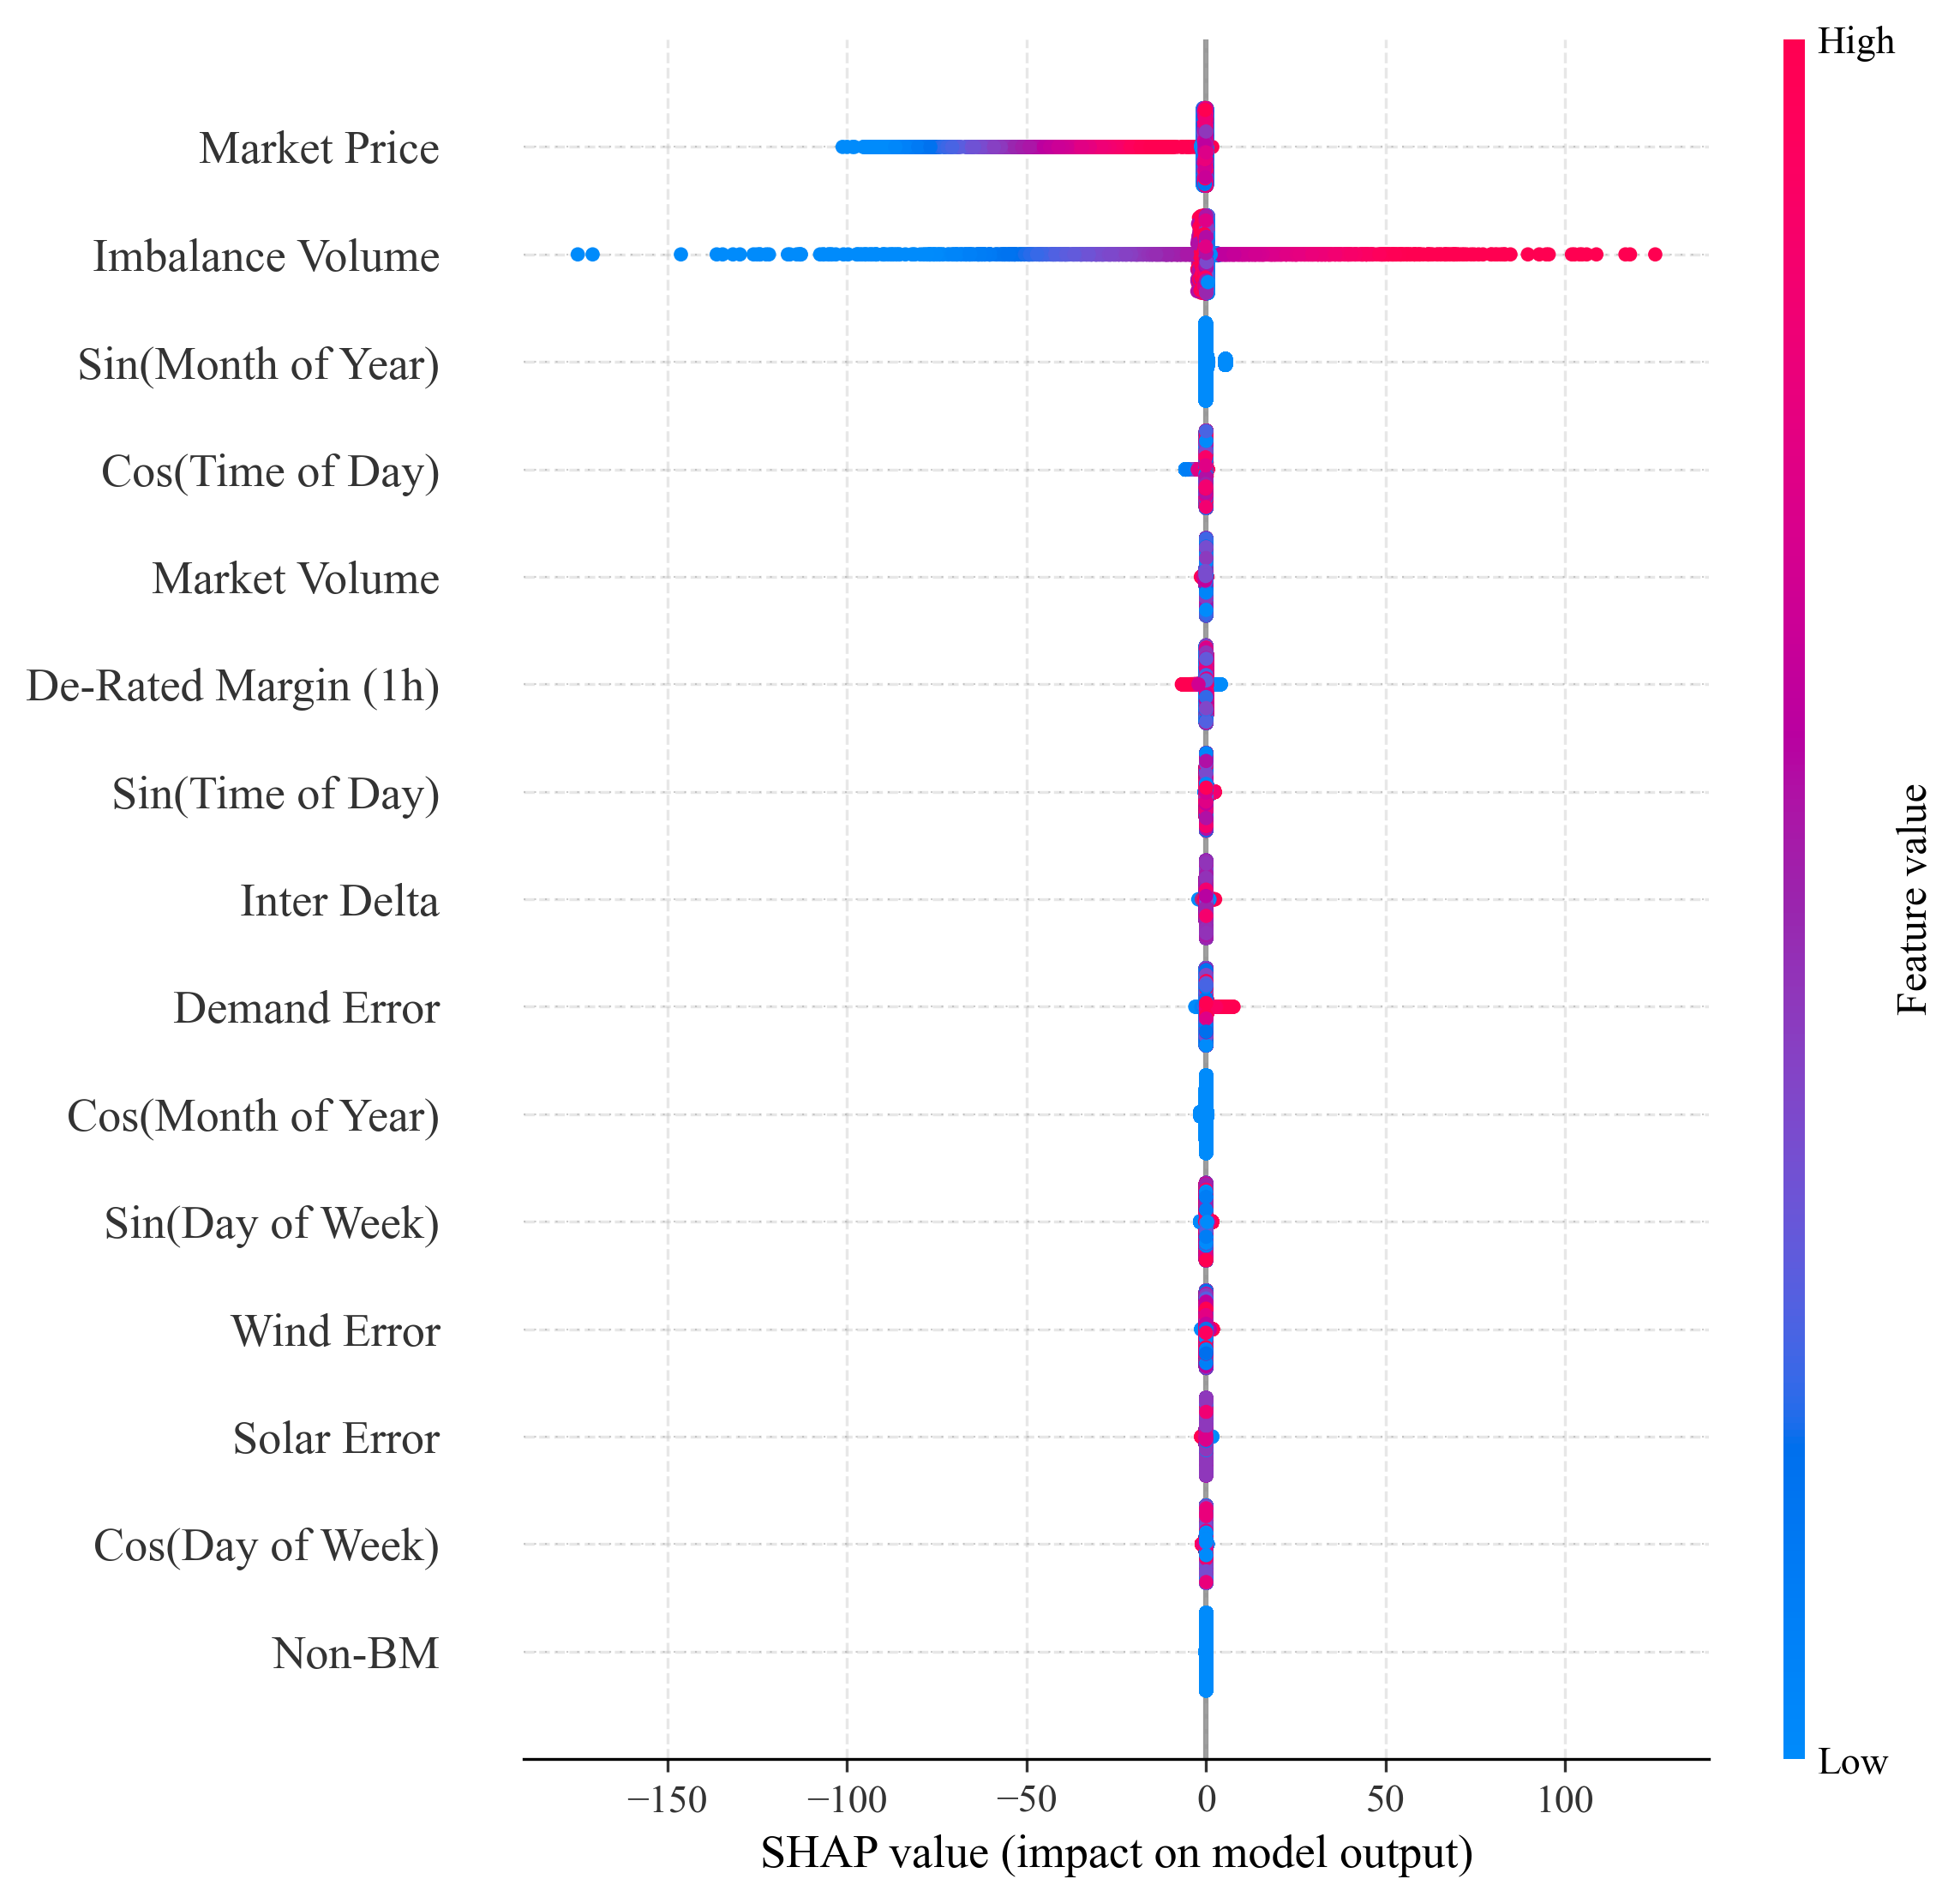

In [ ]:
# shap_gbp has shape (1439, 48, 15)
# X_te_w  has shape (1439, 48, 15)

# Create fancy feature names for more readable plots
fancy_feats = all_feats.copy()
for i, feat in enumerate(all_feats):
    if feat == 'tod_sin':
        fancy_feats[i] = "Sin(Time of Day)"
    elif feat == 'tod_cos':
        fancy_feats[i] = "Cos(Time of Day)"
    elif feat == 'dow_sin':
        fancy_feats[i] = "Sin(Day of Week)"
    elif feat == 'dow_cos':
        fancy_feats[i] = "Cos(Day of Week)"
    elif feat == 'moy_sin':
        fancy_feats[i] = "Sin(Month of Year)"
    elif feat == 'moy_cos':
        fancy_feats[i] = "Cos(Month of Year)"

shap.initjs()
shap.summary_plot(
    vals_flat,
    feat_flat,
    feature_names=fancy_feats,
    max_display=15,
    plot_type="dot",
    show=False
)
plt.gcf()
plt.savefig(os.path.join(plots_dir, "shap_beeswarm.png"), dpi=300)


### Mean Absolute Shap Value with Beeswarm

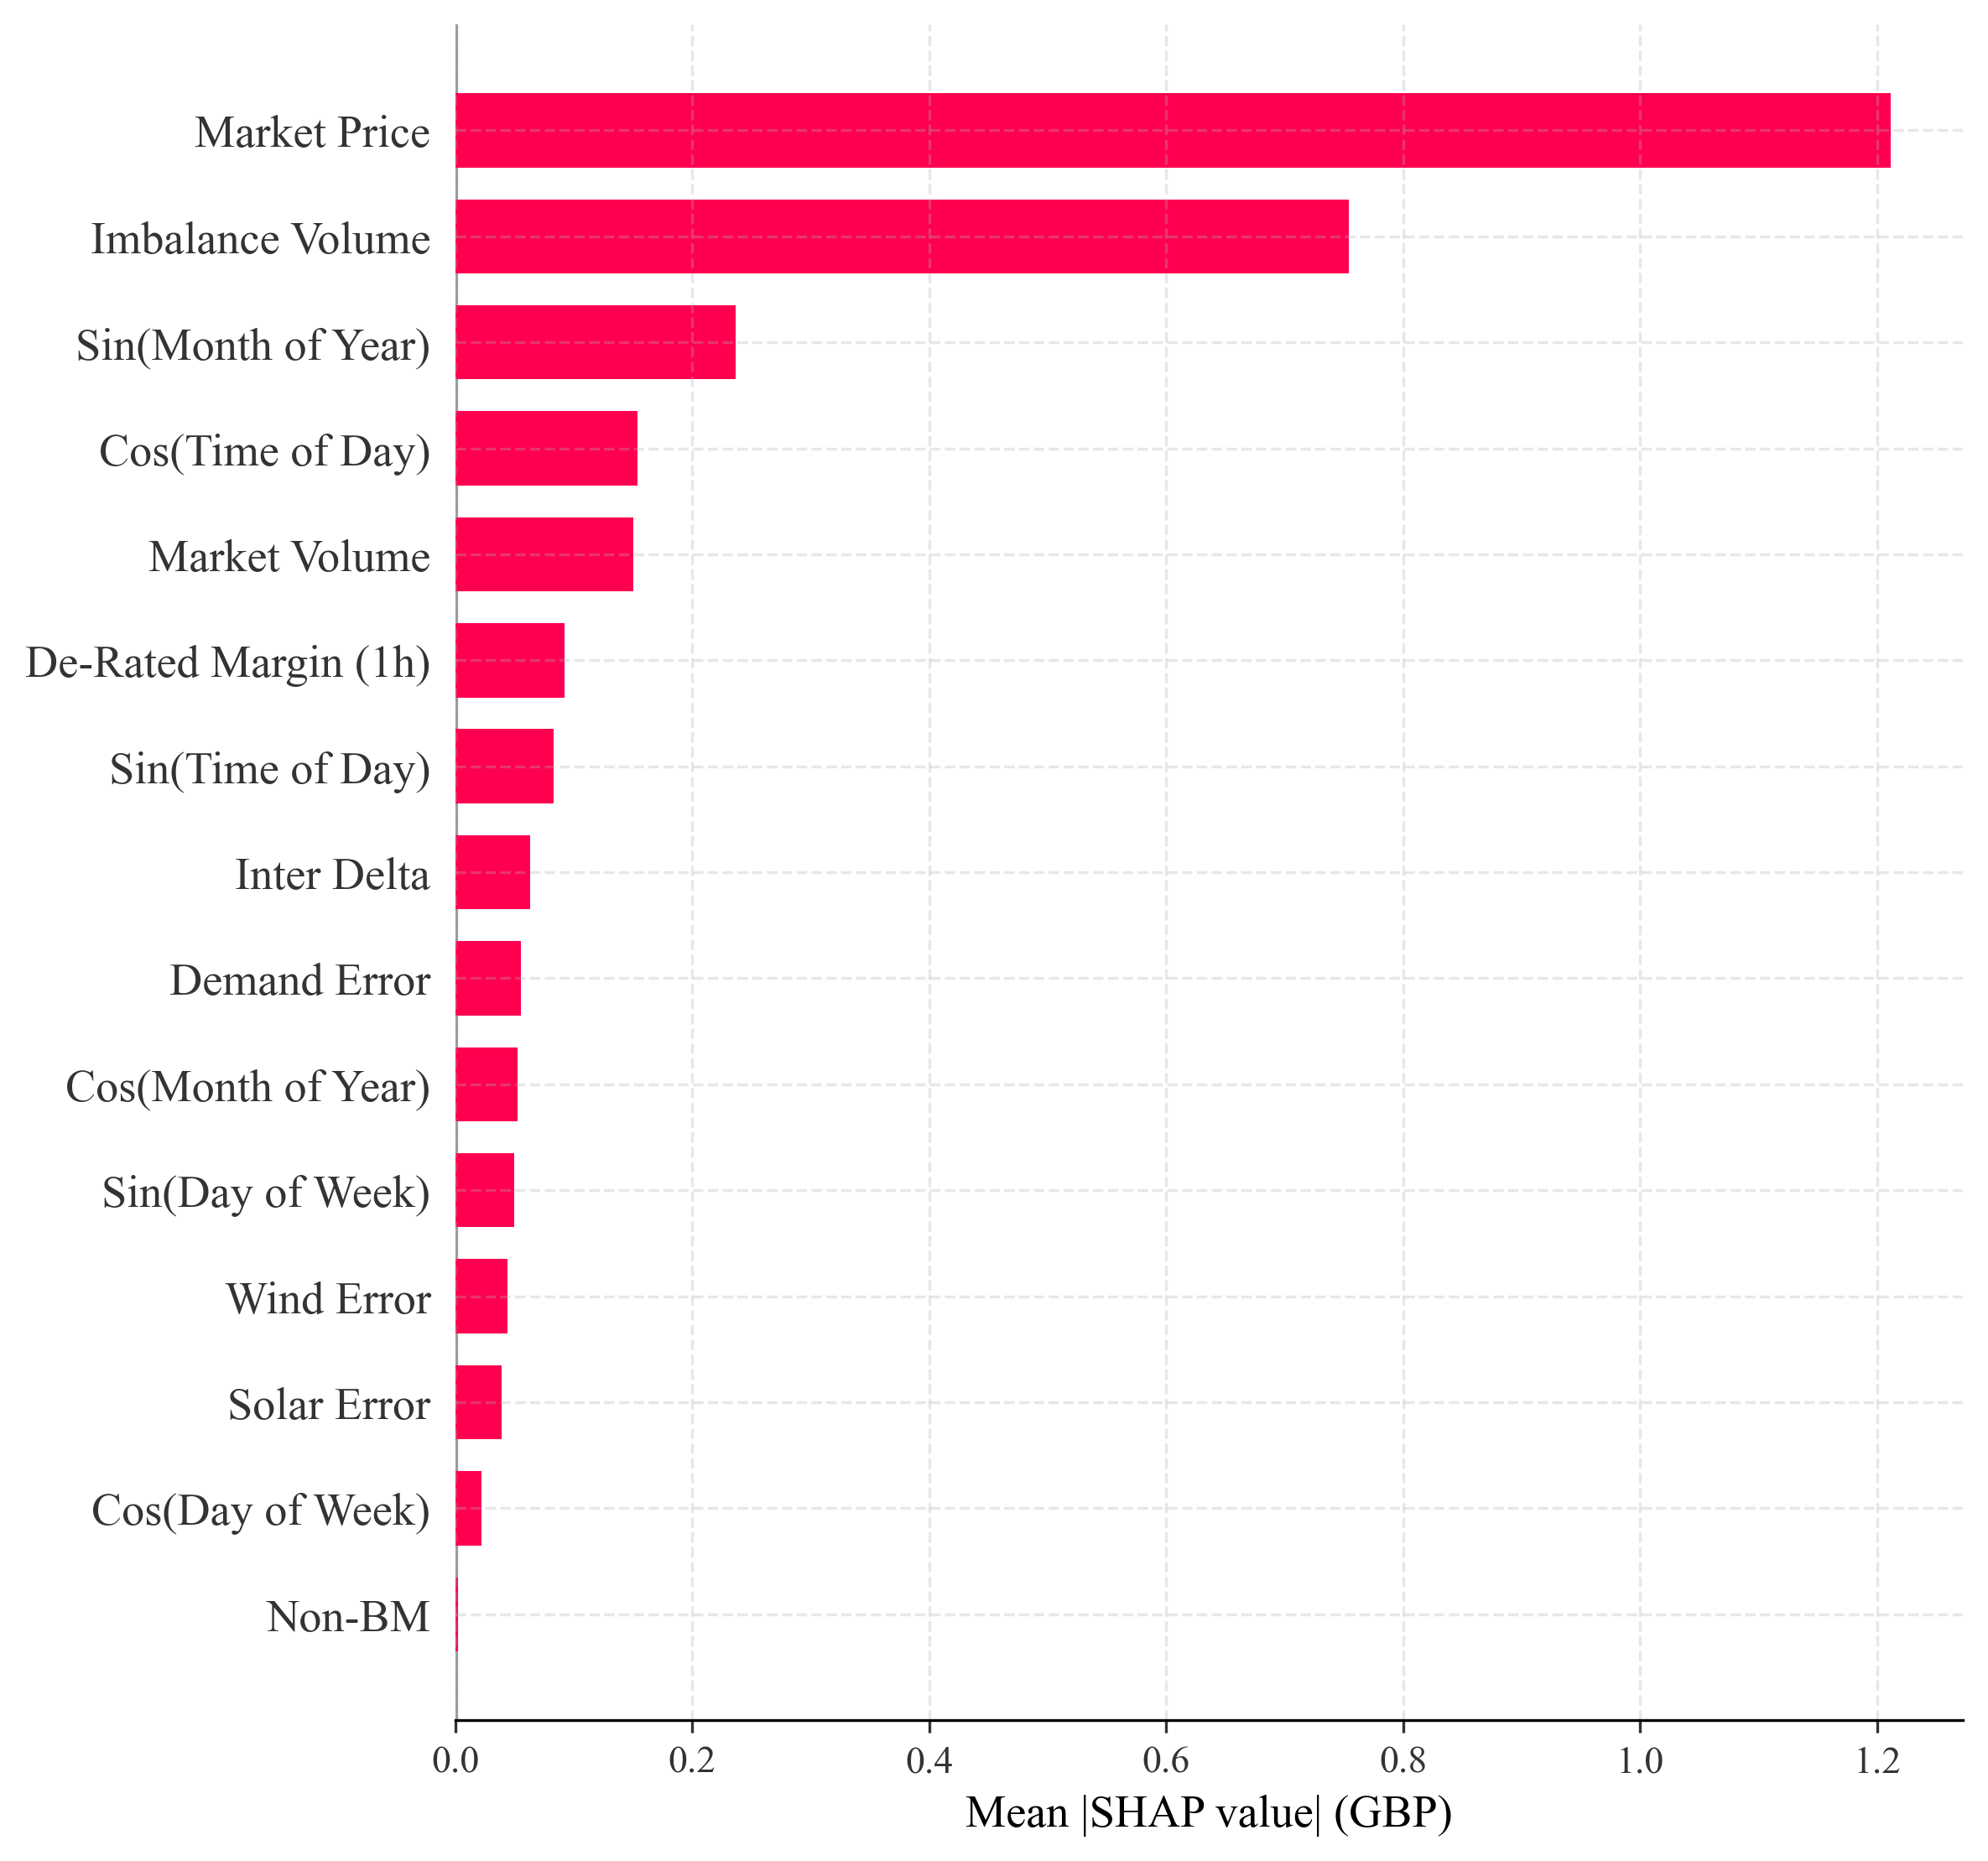

In [ ]:
# 1) Bar plot of mean |SHAP| per feature
mean_abs = np.mean(np.abs(vals_flat), axis=0)  # shape (n_features,)
# Create a dummy features array (not used by bar plot)
feat_dummy = np.zeros((1, vals_flat.shape[1]))

plt.figure(figsize=(10, 6))
shap.summary_plot(
    max_abs[np.newaxis, :],    # a single “sample” of max abs values
    feat_dummy,                # dummy array
    feature_names=fancy_feats,
    plot_type="bar",
    max_display=len(fancy_feats),
    show=False,
    color="#ff0051"
)
plt.xlabel("Max |SHAP value| (GBP)")
plt.ylabel("")               # keep y–labels (features)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "shap_max_bar.png"), dpi=300)
plt.show()

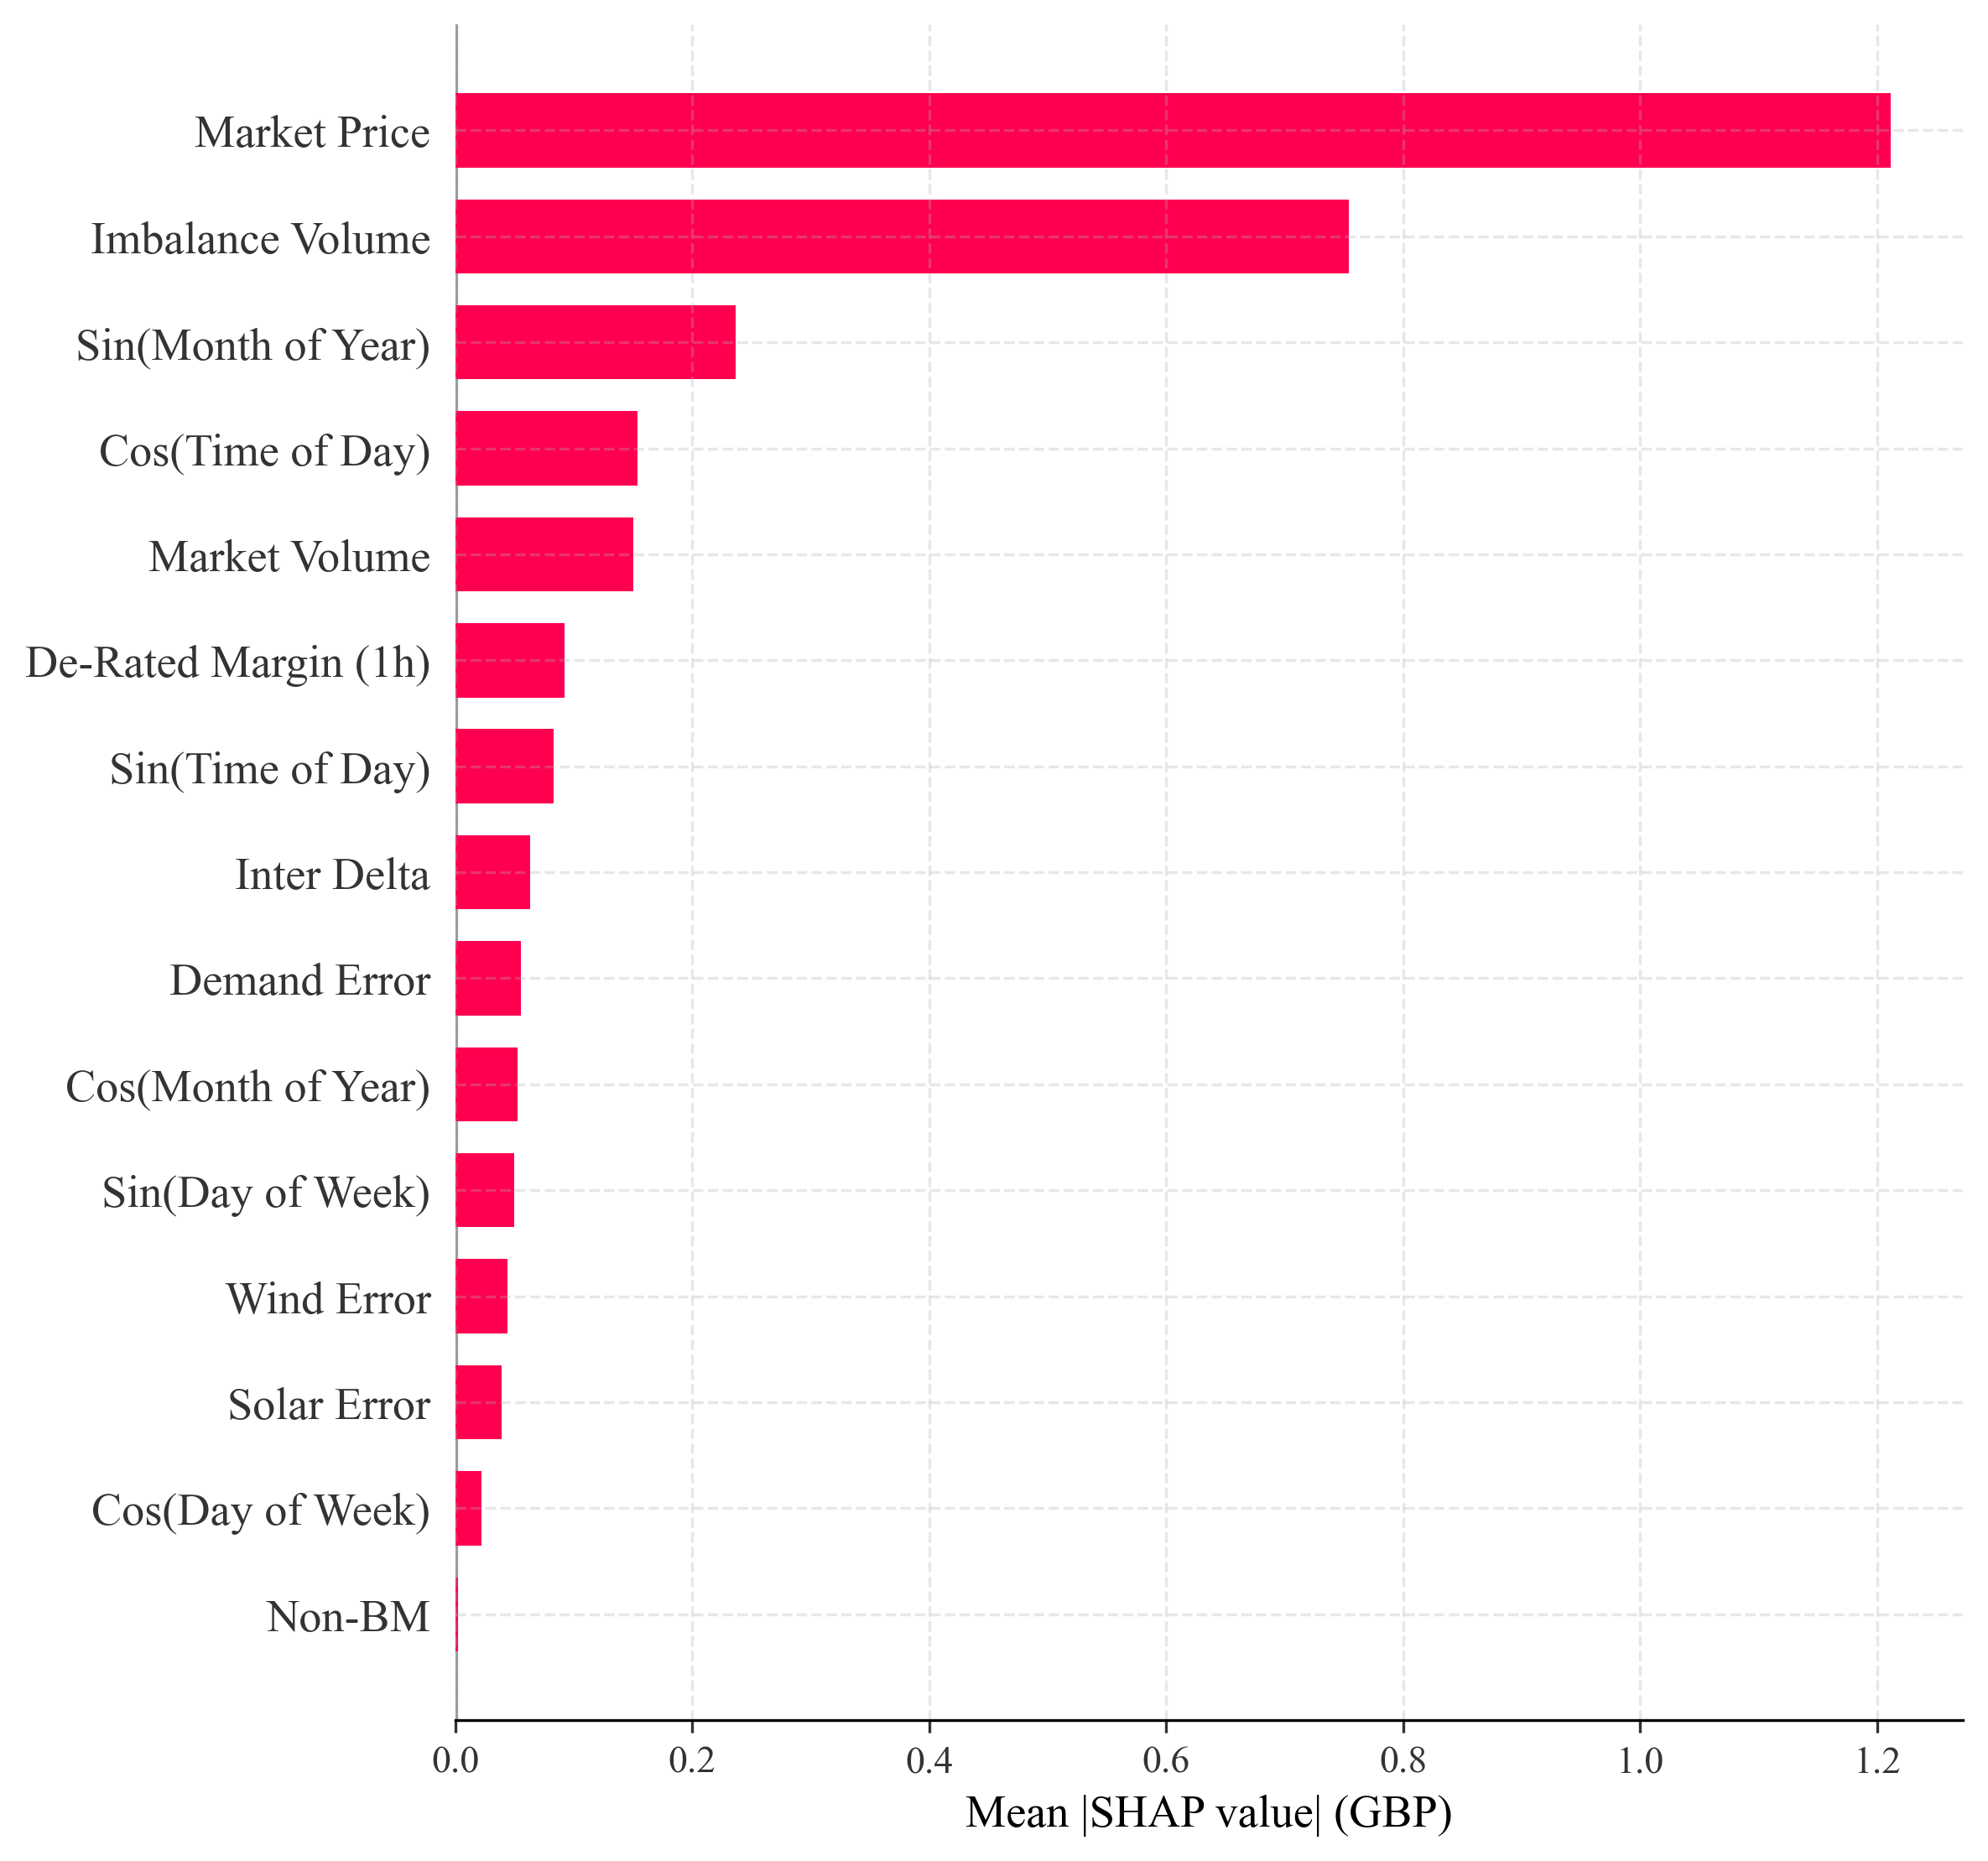

In [133]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    np.abs(vals_flat),        # pass in ALL absolute SHAP values
    feat_flat,                # or np.zeros_like(vals_flat) if you just want bars
    feature_names=fancy_feats,
    plot_type="bar",          # bar = mean(|SHAP|) per feature
    max_display=len(fancy_feats),
    show=False,
    color="#ff0051"           # override default color
)
plt.xlabel("Mean |SHAP value| (GBP)")
plt.ylabel("")               # keep only feature labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "shap_mean_bar.png"), dpi=300)
plt.show()

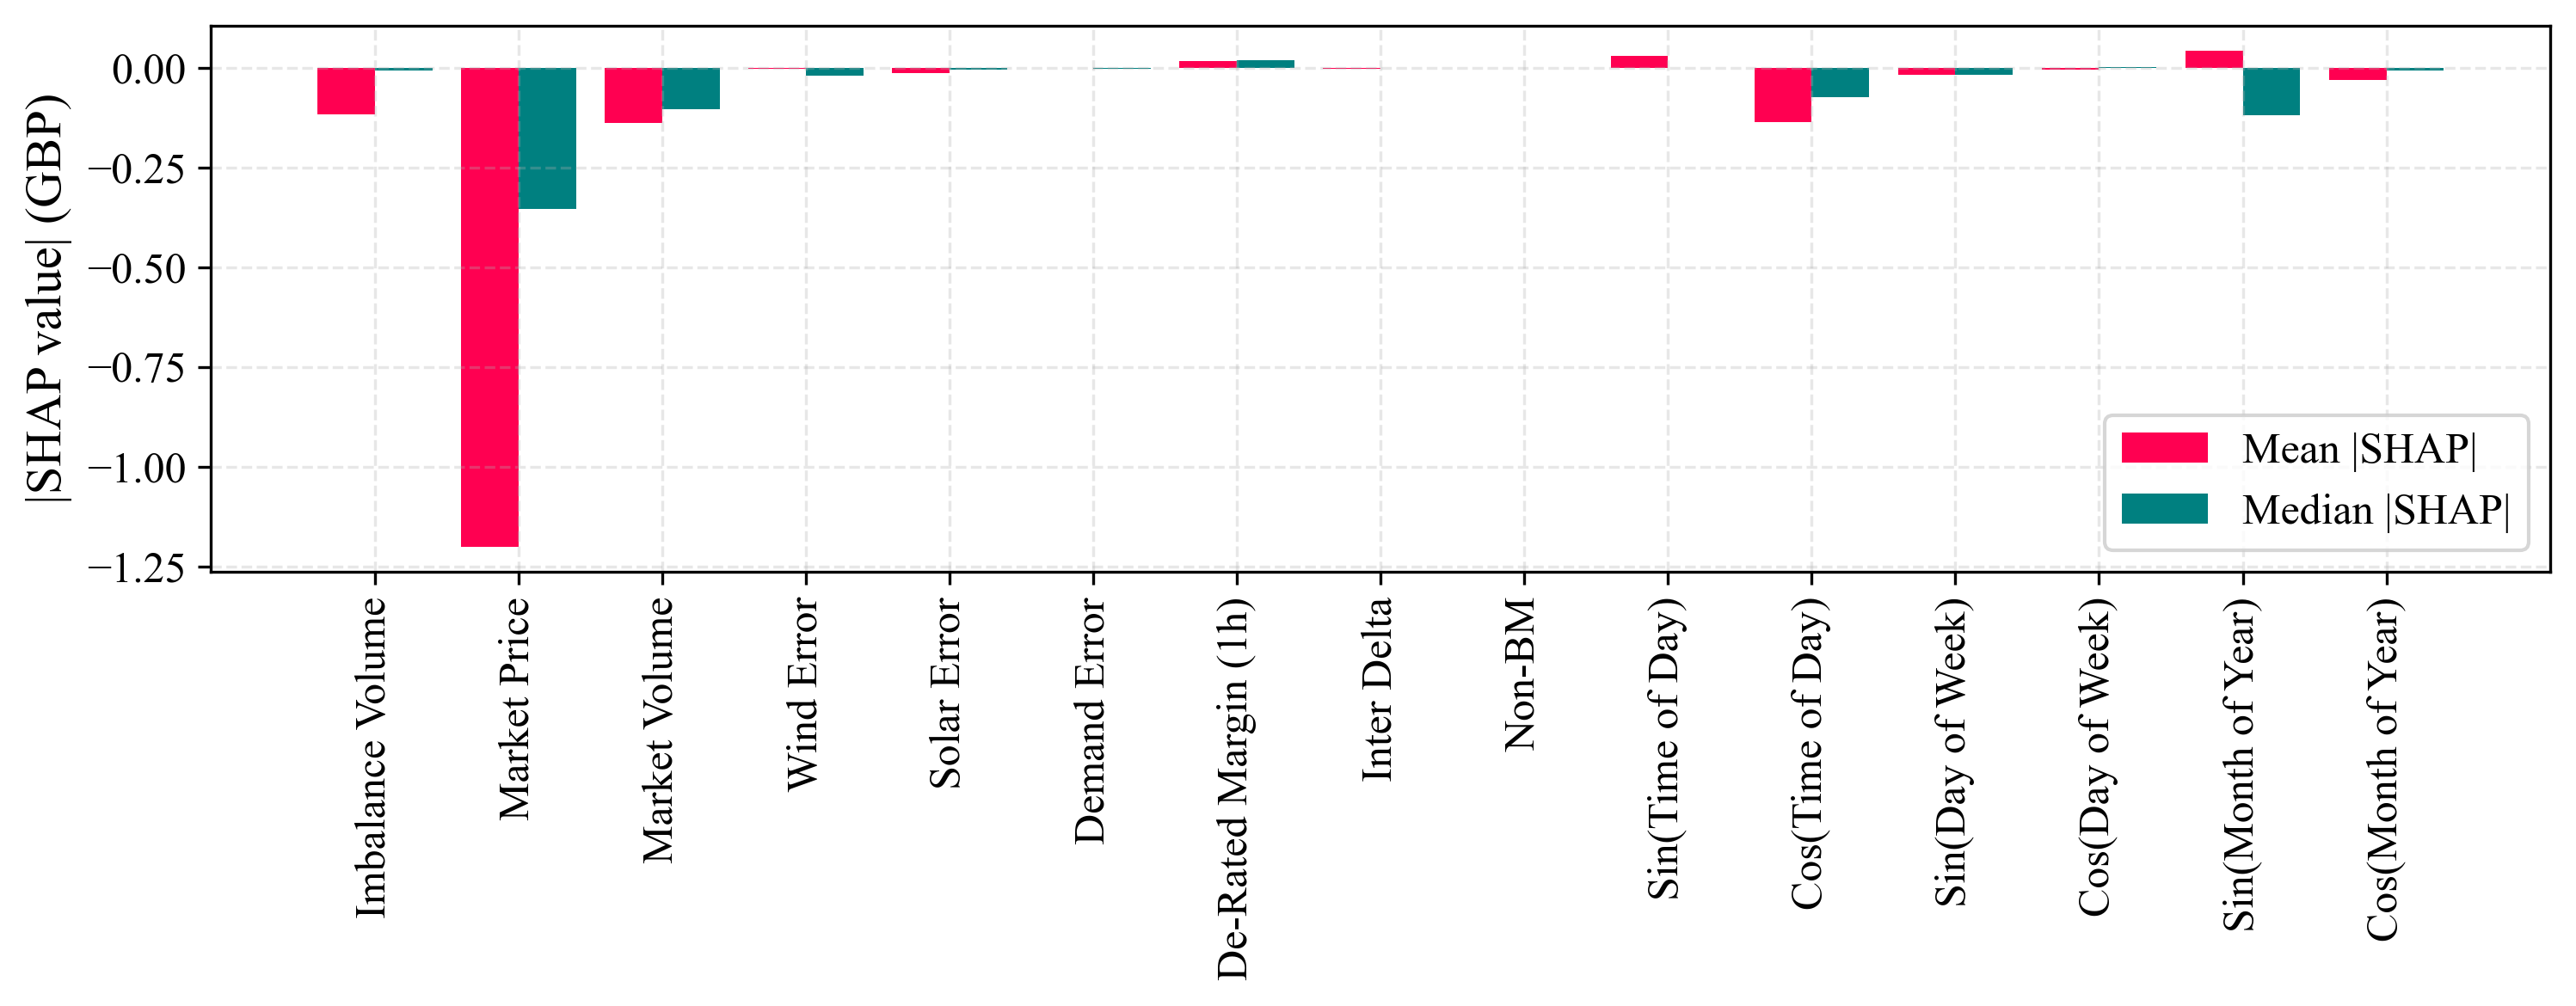

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# vals_flat: (n_samples, n_features) absolute SHAP values
# fancy_feats: list of feature names

mean_abs = np.mean(vals_flat, axis=0)
med_abs  = np.median(vals_flat, axis=0)
x = np.arange(len(fancy_feats))

plt.figure(figsize=(10, 4))
plt.bar(x - 0.2, mean_abs, width=0.4, label="Mean |SHAP|", color="#ff0051")
plt.bar(x + 0.2, med_abs,  width=0.4, label="Median |SHAP|", color="#004680")
plt.xticks(x, fancy_feats, rotation=90)
plt.ylabel("|SHAP value| (GBP)")
plt.legend()
plt.tight_layout()
plt.show()


## Downloading Files (COLAB ONLY)

In [ ]:
import shutil, os
from google.colab import files

shutil.make_archive(tag, 'zip', base_dir)
files.download(f"{tag}.zip")